In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import zipfile
import shutil
from PIL import Image
import numpy as np
import pandas as pd
import time
import dask.bag as db
import dask.diagnostics as dd
import random
from termcolor import colored
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2M, EfficientNetV2B0, EfficientNetV2B3, Xception, ResNet50
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Precision, Recall, F1Score

2024-12-28 11:50:06.063148: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-28 11:50:06.211325: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-28 11:50:06.211363: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-28 11:50:06.211849: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-28 11:50:06.263294: I tensorflow/core/platform/cpu_feature_g

In [2]:
!nvidia-smi

Sat Dec 28 11:50:07 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.57.01              Driver Version: 565.57.01      CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        On  |   00000000:02:00.0 Off |                  Off |
|  0%   29C    P8             23W /  450W |       2MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
CWD = os.getcwd()
CWD

'/workspace'

In [4]:
EPOCHS = 30
SAVE_DIRECTORY = CWD + '/model'

# Load Data

In [5]:
TRAIN_DIR = os.path.join(CWD, 'dataset', 'train_300', 'Training')
TEST_DIR = os.path.join(CWD, 'dataset', 'train_300', 'Testing')
CLASS_DIR = os.path.join(CWD, 'dataset', 'train_300', 'Training')

In [6]:
# Loop over folders to extract class_names
classes = [class_name for class_name in os.listdir(CLASS_DIR) if os.path.isdir(os.path.join(CLASS_DIR, class_name)) and not class_name.startswith('.')]
classes

['glioma', 'meningioma', 'notumor', 'pituitary']

## Prepare Dataset

In [7]:
def prepare_dataset(BASE_DIR, IMG_SIZE, batch_size):
    train_full = tf.keras.utils.image_dataset_from_directory(
        directory=BASE_DIR,        
        labels='inferred',         
        label_mode='categorical',  
        class_names=classes,       
        seed=42,                   
        batch_size=batch_size,             
        image_size=(IMG_SIZE, IMG_SIZE)      
    )

    train_full = train_full.prefetch(tf.data.AUTOTUNE)
    
    # Counting number of all batches in dataset
    num_of_full_train_batches = len(list(train_full))
    print(colored(f'Number of batches in train_full : {num_of_full_train_batches}', 'red', attrs=['bold']))
    
    # Define variable to store number of batches for train dataset
    num_train_batches = int(num_of_full_train_batches * 0.70)
    
    # Define variable to store number of batches for validation and test dataset
    num_valid_test_batches = num_of_full_train_batches - num_train_batches
    
    # Print the TARGET : number of batches for train, validation and test dataset to each
    print(colored(' Target : ', 'green', attrs=['bold']))
    print('-'*35)
    print(colored(f'Number of  Train  batches : {num_train_batches}', 'blue', attrs=['bold']))
    print(colored(f'Number of Validation batches : {num_valid_test_batches//2}', 'blue', attrs=['bold']))
    print(colored(f'Number of Test batches : {num_valid_test_batches//2}', 'blue', attrs=['bold']))

    # Apply above settings to main dataset to split to train, validation and test dataset
    train_ds = train_full.take(num_train_batches)
    remain_ds = train_full.skip(num_train_batches)
    valid_ds = remain_ds.take(num_valid_test_batches)

    train_ds = train_ds.shuffle(buffer_size=3)
    

    test_ds = tf.keras.utils.image_dataset_from_directory(
        directory=TEST_DIR,
        labels='inferred',
        label_mode = 'categorical',
        class_names=classes,
        seed=42,
        batch_size=batch_size,
        image_size=(IMG_SIZE, IMG_SIZE)
    )

    return train_ds, valid_ds, test_ds

In [8]:
def prepare_dataset(BASE_DIR, TEST_DIR, IMG_SIZE, batch_size):
    train_full = tf.keras.utils.image_dataset_from_directory(
        directory=BASE_DIR,        
        labels='inferred',         
        label_mode='categorical',  
        class_names=classes,       
        seed=42,                   
        batch_size=batch_size,             
        image_size=(IMG_SIZE, IMG_SIZE)      
    )

    train_full = train_full.prefetch(tf.data.AUTOTUNE)
    
    # Counting number of all batches in dataset
    num_of_full_train_batches = len(list(train_full))
    print(colored(f'Number of batches in train_full : {num_of_full_train_batches}', 'red', attrs=['bold']))
    
    # Define variable to store number of batches for train dataset
    num_train_batches = int(num_of_full_train_batches * 0.70)
    
    # Define variable to store number of batches for validation and test dataset
    num_valid_test_batches = num_of_full_train_batches - num_train_batches
    
    # Print the TARGET : number of batches for train, validation and test dataset to each
    print(colored(' Target : ', 'green', attrs=['bold']))
    print('-'*35)
    print(colored(f'Number of  Train  batches : {num_train_batches}', 'blue', attrs=['bold']))
    print(colored(f'Number of Validation batches : {num_valid_test_batches//2}', 'blue', attrs=['bold']))
    print(colored(f'Number of Test batches : {num_valid_test_batches//2}', 'blue', attrs=['bold']))

    # Apply above settings to main dataset to split to train, validation and test dataset
    train_ds = train_full.take(num_train_batches)
    valid_ds = train_full.take(num_valid_test_batches)

    train_ds = train_ds.shuffle(buffer_size=3)
    

    test_ds = tf.keras.utils.image_dataset_from_directory(
        directory=TEST_DIR,
        labels='inferred',
        label_mode = 'categorical',
        class_names=classes,
        seed=42,
        batch_size=batch_size,
        image_size=(IMG_SIZE, IMG_SIZE)
    )

    return train_ds, valid_ds, test_ds

## Model Creation

### Not Trainable

In [9]:
def build_model_not_trainable(base_model, input_shape, num_classes):
    input = tf.keras.layers.Input(shape=input_shape)
    
    base_model = base_model(input_shape=input_shape, include_top=False, classes=num_classes, weights='imagenet')

    # Freeze all layers
    base_model.trainable = False

    x = base_model(input, training=False)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)               
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    output = tf.keras.layers.Dense(4, activation='softmax')(x)

    model = tf.keras.Model(inputs=input, outputs=output)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy', F1Score()]
    )

    return model

### First Part

In [10]:
def build_model_trainable_first25(base_model, input_shape, num_classes):
    input = tf.keras.layers.Input(shape=input_shape)
    
    base_model = base_model(input_shape=input_shape, include_top=False, classes=num_classes, weights='imagenet')
    base_model.trainable = True

    # Freeze last 75% layers
    total_layers = len(base_model.layers)
    for layer in base_model.layers[(int(0.75 * total_layers)):]:
        layer.trainable = False

    x = base_model(input, training=False)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)               
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    output = tf.keras.layers.Dense(4, activation='softmax')(x)

    model = tf.keras.Model(inputs=input, outputs=output)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy', F1Score()]
    )

    return model  

In [11]:
def build_model_trainable_first50(base_model, input_shape, num_classes):
    input = tf.keras.layers.Input(shape=input_shape)
    
    base_model = base_model(input_shape=input_shape, include_top=False, classes=num_classes, weights='imagenet')
    base_model.trainable = True

    # Freeze last 50% layers
    total_layers = len(base_model.layers)
    for layer in base_model.layers[(int(0.50 * total_layers)):]:
        layer.trainable = False

    x = base_model(input, training=False)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)               
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    output = tf.keras.layers.Dense(4, activation='softmax')(x)

    model = tf.keras.Model(inputs=input, outputs=output)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy', F1Score()]
    )

    return model  

In [12]:
def build_model_trainable_first75(base_model, input_shape, num_classes):
    input = tf.keras.layers.Input(shape=input_shape)
    
    base_model = base_model(input_shape=input_shape, include_top=False, classes=num_classes, weights='imagenet')
    base_model.trainable = True

    # Freeze last 25% layers
    total_layers = len(base_model.layers)
    for layer in base_model.layers[(int(0.25 * total_layers)):]:
        layer.trainable = False

    x = base_model(input, training=False)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)               
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    output = tf.keras.layers.Dense(4, activation='softmax')(x)

    model = tf.keras.Model(inputs=input, outputs=output)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy', F1Score()]
    )

    return model  

### Last Part

In [13]:
def build_model_trainable_last25(base_model, input_shape, num_classes):
    input = tf.keras.layers.Input(shape=input_shape)
    
    base_model = base_model(input_shape=input_shape, include_top=False, classes=num_classes, weights='imagenet')
    base_model.trainable = True

    # Freeze first 75% layers
    total_layers = len(base_model.layers)
    for layer in base_model.layers[:(int(0.75 * total_layers))]:
        layer.trainable = False

    x = base_model(input, training=False)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)               
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    output = tf.keras.layers.Dense(4, activation='softmax')(x)

    model = tf.keras.Model(inputs=input, outputs=output)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy', F1Score()]
    )

    return model    

In [14]:
def build_model_trainable_last50(base_model, input_shape, num_classes):
    input = tf.keras.layers.Input(shape=input_shape)
    
    base_model = base_model(input_shape=input_shape, include_top=False, classes=num_classes, weights='imagenet')
    base_model.trainable = True

    # Freeze first 50% layers
    total_layers = len(base_model.layers)
    for layer in base_model.layers[:(int(0.50 * total_layers))]:
        layer.trainable = False

    x = base_model(input, training=False)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)               
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    output = tf.keras.layers.Dense(4, activation='softmax')(x)

    model = tf.keras.Model(inputs=input, outputs=output)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy', F1Score()]
    )

    return model    

In [15]:
def build_model_trainable_last75(base_model, input_shape, num_classes):
    input = tf.keras.layers.Input(shape=input_shape)
    
    base_model = base_model(input_shape=input_shape, include_top=False, classes=num_classes, weights='imagenet')
    base_model.trainable = True

    # Freeze first 25% layers
    total_layers = len(base_model.layers)
    for layer in base_model.layers[:(int(0.25 * total_layers))]:
        layer.trainable = False

    x = base_model(input, training=False)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)               
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    output = tf.keras.layers.Dense(4, activation='softmax')(x)

    model = tf.keras.Model(inputs=input, outputs=output)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy', F1Score()]
    )

    return model    

### Full Trainable

In [16]:
def build_model_full_trainable(base_model, input_shape, num_classes):
    input = tf.keras.layers.Input(shape=input_shape)
    
    base_model = base_model(input_shape=input_shape, include_top=False, classes=num_classes, weights='imagenet')

    # Full Trainable
    base_model.trainable = True

    x = base_model(input, training=False)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)               
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    output = tf.keras.layers.Dense(4, activation='softmax')(x)

    model = tf.keras.Model(inputs=input, outputs=output)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy', F1Score()]
    )

    return model    

## Train Function

In [17]:
def train(model, model_name, train_ds, valid_ds, epochs, save_directory):
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)

    saving_path = os.path.join(save_directory, f'model_{model_name}.h5')

    # Model CheckPoint Call-Back, to save best model parameters as a .keras file
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(saving_path, monitor='val_accuracy', save_best_only=True)

    # Early Stoping Call-Backc to stop trainig process after 'patience' epochs if the metric doesn't grow
    #earlystop_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

    # ReduceLROnPlateau Call-Back to decrease learning-rate base on 'monitor' parameter after 'patience' epochs with a 'factor' is doesn't improve
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

    start = time.time()

    # Model training
    history = model.fit(
        train_ds,
        epochs=epochs,
        validation_data = valid_ds,
        callbacks=[checkpoint_cb, reduce_lr]
    )

    end = time.time()

    # Counting trianing time
    training_time = end - start
    print(f"Training completed in {training_time:.2f} seconds.")

    return model, history, training_time

## Best Model Selection Function

In [18]:
def best_variant(models, test_ds, output_csv, output_folder='results'):
    """
    Compare multiple models, select the best based on F1 Score, and save results to a CSV.

    Args:
        models (list of tuples): List of (model_name, model, history, time) tuples.
        test_ds: The test dataset for evaluation.
        output_csv (str): The name of the output CSV file.
        output_folder (str): The directory to save the results.
        
    Returns:
        Tuple containing the best model's name, test loss, test accuracy, test F1 score, and training time.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Evaluate each model and collect results
    models_info = []

    for model_name, model, history, time in models:
        # Assume val_accuracy as a proxy for F1 score
        val_f1score = max(history.history['val_accuracy'])
        val_loss = min(history.history['val_loss'])
        val_acc = max(history.history['val_accuracy'])

        # Store each model's information in models_info
        models_info.append({
            'Model Name': model_name,
            'Model': model,
            'Loss': val_loss,
            'Accuracy': val_acc,
            'F1 Score': val_f1score,
            'Training Time': time,
            'History': history
        })

    # Sort the models by F1 Score in descending order
    models_info = sorted(models_info, key=lambda x: x['F1 Score'], reverse=True)

    # Convert to DataFrame for a neat tabular display
    df = pd.DataFrame([{k: v for k, v in m.items() if k != 'Model' and k != 'History'} for m in models_info])

    # Save to CSV
    output_path = os.path.join(output_folder, output_csv)
    df.to_csv(output_path, index=False)
    print(f"Model comparison table saved to {output_path}")

    # Print DataFrame
    print("Model Comparison Table:")
    print(df)

    # Select the best model based on F1 Score
    best_model_info = models_info[0]
    best_model = best_model_info['Model']
    best_model_name = best_model_info['Model Name']
    best_history = best_model_info['History']
    best_time = best_model_info['Training Time']

    # Evaluate on the test dataset using plot function
    best_history, test_loss, test_acc, test_f1score = plot(best_model, best_history, test_ds, f"results/{best_model_name}",  best_model_name)

    # Return the best model's evaluation results for updating result_dict later
    return best_model_name, test_loss, test_acc, test_f1score, best_time

## Plot Function

In [19]:
def plot(model, history, test_ds, output_folder='results', prefix='model'):
    """
    Plot training results, confusion matrix, and save plots to files.

    Args:
        model: The trained model.
        history: Training history object from model.fit().
        test_ds: Test dataset for evaluation.
        output_folder (str): Directory to save plots.
        prefix (str): Prefix for output file names.

    Returns:
        Tuple containing history, test loss, test accuracy, and test F1 score.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Convert result of training to DataFrame
    result = pd.DataFrame(history.history)

    # Define a variable to store range of epochs
    x = np.arange(len(result))

    # Create a plot with 2 rows and 1 column with size of (15, 12)
    fig, ax = plt.subplots(2, 1, figsize=(15, 12))

    # AX0 : Loss
    ax[0].plot(x, result.loss, label='Loss', linewidth=3)
    ax[0].plot(x, result.val_loss, label='Validation Loss', linewidth=2)
    ax[0].set_title('Loss', fontsize=20)
    ax[0].set_xticks(np.arange(0, len(x), 2))
    ax[0].legend()

    # AX1 : Accuracy
    ax[1].plot(x, result.accuracy, label='Accuracy', linewidth=2)
    ax[1].plot(x, result.val_accuracy, label='Validation Accuracy', linewidth=2)
    ax[1].set_title('Accuracy', fontsize=20)
    ax[1].set_xticks(np.arange(0, len(x), 2))
    ax[1].legend()

    # Save accuracy and loss plot
    acc_loss_plot_path = os.path.join(output_folder, f"{prefix}_acc_loss_plot.png")
    plt.savefig(acc_loss_plot_path)
    print(f"Accuracy and Loss plot saved to {acc_loss_plot_path}")

    # Evaluate model
    test_loss, test_acc, test_f1score = model.evaluate(test_ds, verbose=1)

    # Confusion Matrix
    y_pred = []
    y_true = []

    for images, labels in test_ds:
        predictions = model.predict(images)
        y_pred.extend(np.argmax(predictions, axis=1))

        # If labels are one-hot encoded, convert to class indices
        if len(labels.shape) > 1:
            labels = np.argmax(labels, axis=1)
        y_true.extend(labels)

    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Get the class names from the dataset
    class_names = sorted(set(y_true))  # Infer class names from true labels

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)

    # Save confusion matrix plot
    cm_plot_path = os.path.join(output_folder, f"{prefix}_confusion_matrix.png")
    plt.savefig(cm_plot_path)
    print(f"Confusion Matrix plot saved to {cm_plot_path}")

    # Classification Report
    print('Classification Report')
    cr = classification_report(y_true, y_pred, digits=5, target_names=[str(c) for c in class_names])
    print(cr)

    # Save classification report to a text file
    cr_path = os.path.join(output_folder, f"{prefix}_classification_report.txt")
    with open(cr_path, 'w') as f:
        f.write('Classification Report\n')
        f.write(cr)
    print(f"Classification Report saved to {cr_path}")

    # Show all plots
    plt.show()

    return history, test_loss, test_acc, test_f1score

In [20]:
def save_results_to_csv(result_dict, file_path='results/results.csv'):
    # Convert result_dict to DataFrame
    df = pd.DataFrame(result_dict)
    
    # Save the combined DataFrame to CSV
    df.to_csv(file_path, index=False)
    print(f"Results saved to {file_path}")

# Function to load results from a CSV file
def load_results_from_csv(file_path='results/result.csv'):
    # If the file exists, load it; otherwise, return an empty dictionary
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        result_dict =  df.to_dict(orient='list')
    else:
        result_dict =  {
            'Model Name': [],
            'Test Loss': [],
            'Test Accuracy': [],
            'Test F1Score': [],
            'Training Time': []
        }
    return result_dict

In [21]:
def result(model_name, test_loss, test_acc, test_f1score, result_dict, training_time):
    
    test_f1score = test_f1score[1] if isinstance(test_f1score, (list, np.ndarray)) else test_f1score
    
    result_dict['Model Name'].append(model_name)
    result_dict['Test Loss'].append(test_loss)
    result_dict['Test Accuracy'].append(test_acc)
    result_dict['Test F1Score'].append(test_f1score)
    result_dict['Training Time'].append(training_time)
    
    save_results_to_csv(result_dict, 'results/result.csv')

result_dict = {
    'Model Name': [],
    'Test Loss': [],
    'Test Accuracy': [],
    'Test F1Score': [],
    'Training Time': []
}

# Prepare training dataset

In [27]:
train_dir_300 = CWD + "/dataset/train_300/Training"
test_dir_300= CWD + "/dataset/train_300/Testing"

In [28]:
train_ds_300, valid_ds_300, test_ds_300 = prepare_dataset(train_dir_300, test_dir_300, 300, 16)

Found 5712 files belonging to 4 classes.


2024-12-28 11:52:05.470458: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Number of batches in train_full : 357
 Target : 
-----------------------------------
Number of  Train  batches : 249
Number of Validation batches : 54
Number of Test batches : 54
Found 1311 files belonging to 4 classes.


# Model Training

## Standard

### EfficientNetV2B0

#### not trainable

In [26]:
model_name_1 = 'EfficientnetV2B0 Without Augmentation Not Trainable'
input_shape = (300,300,3)

std_b0_nt = build_model_not_trainable(EfficientNetV2B0, input_shape=input_shape, num_classes=4)
std_b0_nt, history_std_b0_nt, training_time_1 = train(std_b0_nt, model_name_1, train_ds_300, valid_ds_300, EPOCHS, SAVE_DIRECTORY)

24274472/24274472 [==============================] - 2s 0us/step
Epoch 1/30


2024-12-10 13:19:48.927345: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8905
2024-12-10 13:19:48.967775: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-12-10 13:19:49.679600: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f6be4e11c60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-10 13:19:49.679622: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-12-10 13:19:49.683619: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-10 13:19:49.736185: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


249/249 [==============================] - 7s 16ms/step - loss: 0.8528 - accuracy: 0.6672 - f1_score: 0.6516 - val_loss: 0.4762 - val_accuracy: 0.8640 - val_f1_score: 0.8627 - lr: 1.0000e-04
Epoch 2/30


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


249/249 [==============================] - 3s 14ms/step - loss: 0.4768 - accuracy: 0.8281 - f1_score: 0.8217 - val_loss: 0.3422 - val_accuracy: 0.8872 - val_f1_score: 0.8856 - lr: 1.0000e-04
Epoch 3/30
249/249 [==============================] - 3s 13ms/step - loss: 0.3943 - accuracy: 0.8592 - f1_score: 0.8545 - val_loss: 0.3054 - val_accuracy: 0.8981 - val_f1_score: 0.8970 - lr: 1.0000e-04
Epoch 4/30
249/249 [==============================] - 3s 14ms/step - loss: 0.3402 - accuracy: 0.8805 - f1_score: 0.8763 - val_loss: 0.2720 - val_accuracy: 0.9103 - val_f1_score: 0.9093 - lr: 1.0000e-04
Epoch 5/30
249/249 [==============================] - 3s 13ms/step - loss: 0.3140 - accuracy: 0.8903 - f1_score: 0.8870 - val_loss: 0.2385 - val_accuracy: 0.9149 - val_f1_score: 0.9139 - lr: 1.0000e-04
Epoch 6/30
249/249 [==============================] - 3s 14ms/step - loss: 0.2813 - accuracy: 0.9066 - f1_score: 0.9040 - val_loss: 0.2141 - val_accuracy: 0.9236 - val_f1_score: 0.9226 - lr: 1.0000e-04
E

#### trainable first 25% layers

In [27]:
model_name_2 = "EfficientnetV2B0 Without Augmentation Trainable First 25% Layer"
input_shape = (300,300,3)

std_b0_tf25 = build_model_trainable_first25(EfficientNetV2B0, input_shape=input_shape, num_classes=4)
std_b0_tf25, history_std_b0_tf25, training_time_2 = train(std_b0_tf25, model_name_2, train_ds_300, valid_ds_300, EPOCHS, SAVE_DIRECTORY)

Epoch 1/30


2024-12-10 13:21:37.641451: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


249/249 [==============================] - 20s 30ms/step - loss: 0.5666 - accuracy: 0.7811 - f1_score: 0.7755 - val_loss: 0.3119 - val_accuracy: 0.9097 - val_f1_score: 0.9073 - lr: 1.0000e-04
Epoch 2/30
249/249 [==============================] - 7s 28ms/step - loss: 0.2088 - accuracy: 0.9247 - f1_score: 0.9226 - val_loss: 0.0888 - val_accuracy: 0.9705 - val_f1_score: 0.9701 - lr: 1.0000e-04
Epoch 3/30
249/249 [==============================] - 7s 28ms/step - loss: 0.1016 - accuracy: 0.9649 - f1_score: 0.9638 - val_loss: 0.0497 - val_accuracy: 0.9855 - val_f1_score: 0.9853 - lr: 1.0000e-04
Epoch 4/30
249/249 [==============================] - 7s 27ms/step - loss: 0.0624 - accuracy: 0.9787 - f1_score: 0.9781 - val_loss: 0.0498 - val_accuracy: 0.9838 - val_f1_score: 0.9838 - lr: 1.0000e-04
Epoch 5/30
249/249 [==============================] - 7s 28ms/step - loss: 0.0528 - accuracy: 0.9819 - f1_score: 0.9816 - val_loss: 0.0239 - val_accuracy: 0.9936 - val_f1_score: 0.9935 - lr: 1.0000e-04


#### trainable first 50% layers

In [28]:
model_name_3 = 'EfficientnetV2B0 Without Augmentation Trainable First 50% Layer'
input_shape = (300,300,3)

std_b0_tf50 = build_model_trainable_first50(EfficientNetV2B0, input_shape=input_shape, num_classes=4)
std_b0_tf50, history_std_b0_tf50, training_time_3 = train(std_b0_tf50, model_name_3, train_ds_300, valid_ds_300, EPOCHS, SAVE_DIRECTORY)

Epoch 1/30


2024-12-10 13:25:15.046946: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


249/249 [==============================] - 15s 29ms/step - loss: 0.6058 - accuracy: 0.7693 - f1_score: 0.7612 - val_loss: 0.2820 - val_accuracy: 0.9016 - val_f1_score: 0.9008 - lr: 1.0000e-04
Epoch 2/30
249/249 [==============================] - 7s 26ms/step - loss: 0.2623 - accuracy: 0.9041 - f1_score: 0.9021 - val_loss: 0.1821 - val_accuracy: 0.9381 - val_f1_score: 0.9373 - lr: 1.0000e-04
Epoch 3/30
249/249 [==============================] - 7s 26ms/step - loss: 0.1485 - accuracy: 0.9490 - f1_score: 0.9478 - val_loss: 0.0894 - val_accuracy: 0.9745 - val_f1_score: 0.9743 - lr: 1.0000e-04
Epoch 4/30
249/249 [==============================] - 7s 26ms/step - loss: 0.0891 - accuracy: 0.9686 - f1_score: 0.9679 - val_loss: 0.0408 - val_accuracy: 0.9861 - val_f1_score: 0.9859 - lr: 1.0000e-04
Epoch 5/30
249/249 [==============================] - 7s 26ms/step - loss: 0.0455 - accuracy: 0.9854 - f1_score: 0.9852 - val_loss: 0.0220 - val_accuracy: 0.9942 - val_f1_score: 0.9941 - lr: 1.0000e-04


#### trainable first 75% layers

In [29]:
model_name_4 = 'EfficientnetV2B0 Without Augmentation Trainable First 75% Layer'
input_shape = (300,300,3)

std_b0_tf75 = build_model_trainable_first75(EfficientNetV2B0, input_shape=input_shape, num_classes=4)
std_b0_tf75, history_std_b0_tf75, training_time_4 = train(std_b0_tf75, model_name_4, train_ds_300, valid_ds_300, EPOCHS, SAVE_DIRECTORY)

Epoch 1/30


2024-12-10 13:28:38.332953: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_3/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


249/249 [==============================] - 12s 27ms/step - loss: 0.7687 - accuracy: 0.7013 - f1_score: 0.6964 - val_loss: 0.3841 - val_accuracy: 0.8536 - val_f1_score: 0.8418 - lr: 1.0000e-04
Epoch 2/30
249/249 [==============================] - 6s 25ms/step - loss: 0.3717 - accuracy: 0.8685 - f1_score: 0.8642 - val_loss: 0.2642 - val_accuracy: 0.9045 - val_f1_score: 0.9040 - lr: 1.0000e-04
Epoch 3/30
249/249 [==============================] - 6s 25ms/step - loss: 0.2743 - accuracy: 0.9041 - f1_score: 0.9012 - val_loss: 0.2003 - val_accuracy: 0.9242 - val_f1_score: 0.9221 - lr: 1.0000e-04
Epoch 4/30
249/249 [==============================] - 6s 25ms/step - loss: 0.2224 - accuracy: 0.9212 - f1_score: 0.9193 - val_loss: 0.1384 - val_accuracy: 0.9549 - val_f1_score: 0.9542 - lr: 1.0000e-04
Epoch 5/30
249/249 [==============================] - 6s 24ms/step - loss: 0.1805 - accuracy: 0.9370 - f1_score: 0.9354 - val_loss: 0.1588 - val_accuracy: 0.9329 - val_f1_score: 0.9327 - lr: 1.0000e-04


#### trainable last 25% layers

In [30]:
model_name_5 = 'EfficientnetV2B0 Without Augmentation Trainable Last 25% Layer'
input_shape = (300,300,3)

std_b0_tl25 = build_model_trainable_last25(EfficientNetV2B0, input_shape=input_shape, num_classes=4)
std_b0_tl25, history_std_b0_tl25, training_time_5 = train(std_b0_tl25, model_name_5, train_ds_300, valid_ds_300, EPOCHS, SAVE_DIRECTORY)

Epoch 1/30


2024-12-10 13:31:49.674943: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_4/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


249/249 [==============================] - 10s 19ms/step - loss: 0.5265 - accuracy: 0.7947 - f1_score: 0.7877 - val_loss: 0.1971 - val_accuracy: 0.9230 - val_f1_score: 0.9207 - lr: 1.0000e-04
Epoch 2/30
249/249 [==============================] - 4s 17ms/step - loss: 0.1895 - accuracy: 0.9322 - f1_score: 0.9304 - val_loss: 0.0791 - val_accuracy: 0.9682 - val_f1_score: 0.9677 - lr: 1.0000e-04
Epoch 3/30
249/249 [==============================] - 4s 17ms/step - loss: 0.0826 - accuracy: 0.9694 - f1_score: 0.9686 - val_loss: 0.0474 - val_accuracy: 0.9815 - val_f1_score: 0.9812 - lr: 1.0000e-04
Epoch 4/30
249/249 [==============================] - 4s 17ms/step - loss: 0.0499 - accuracy: 0.9847 - f1_score: 0.9843 - val_loss: 0.0125 - val_accuracy: 0.9977 - val_f1_score: 0.9976 - lr: 1.0000e-04
Epoch 5/30
249/249 [==============================] - 4s 16ms/step - loss: 0.0322 - accuracy: 0.9895 - f1_score: 0.9891 - val_loss: 0.0141 - val_accuracy: 0.9959 - val_f1_score: 0.9959 - lr: 1.0000e-04


#### trainable last 50% layers

In [31]:
model_name_6 = 'EfficientnetV2B0 Without Augmentation Trainable Last 50% Layer'
input_shape = (300,300,3)

std_b0_tl50 = build_model_trainable_last50(EfficientNetV2B0, input_shape=input_shape, num_classes=4)
std_b0_tl50, history_std_b0_tl50, training_time_6 = train(std_b0_tl50, model_name_6, train_ds_300, valid_ds_300, EPOCHS, SAVE_DIRECTORY)

Epoch 1/30


2024-12-10 13:33:54.708407: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_5/dropout_10/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


249/249 [==============================] - 13s 21ms/step - loss: 0.5578 - accuracy: 0.7821 - f1_score: 0.7744 - val_loss: 0.1964 - val_accuracy: 0.9329 - val_f1_score: 0.9319 - lr: 1.0000e-04
Epoch 2/30
249/249 [==============================] - 5s 19ms/step - loss: 0.2123 - accuracy: 0.9310 - f1_score: 0.9291 - val_loss: 0.1049 - val_accuracy: 0.9578 - val_f1_score: 0.9578 - lr: 1.0000e-04
Epoch 3/30
249/249 [==============================] - 5s 19ms/step - loss: 0.1054 - accuracy: 0.9649 - f1_score: 0.9639 - val_loss: 0.0470 - val_accuracy: 0.9815 - val_f1_score: 0.9813 - lr: 1.0000e-04
Epoch 4/30
249/249 [==============================] - 5s 18ms/step - loss: 0.0725 - accuracy: 0.9759 - f1_score: 0.9752 - val_loss: 0.0871 - val_accuracy: 0.9676 - val_f1_score: 0.9669 - lr: 1.0000e-04
Epoch 5/30
249/249 [==============================] - 5s 19ms/step - loss: 0.0294 - accuracy: 0.9910 - f1_score: 0.9906 - val_loss: 0.0697 - val_accuracy: 0.9763 - val_f1_score: 0.9755 - lr: 1.0000e-04


#### trainable last 75% layers

In [32]:
model_name_7 = 'EfficientnetV2B0 Without Augmentation Trainable Last 75% Layer'
input_shape = (300,300,3)

std_b0_tl75 = build_model_trainable_last75(EfficientNetV2B0, input_shape=input_shape, num_classes=4)
std_b0_tl75, history_std_b0_tl75, training_time_7 = train(std_b0_tl75, model_name_7, train_ds_300, valid_ds_300, EPOCHS, SAVE_DIRECTORY)

Epoch 1/30


2024-12-10 13:36:33.166503: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/dropout_12/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


249/249 [==============================] - 18s 27ms/step - loss: 0.4565 - accuracy: 0.8251 - f1_score: 0.8209 - val_loss: 0.2458 - val_accuracy: 0.9149 - val_f1_score: 0.9141 - lr: 1.0000e-04
Epoch 2/30
249/249 [==============================] - 6s 24ms/step - loss: 0.1428 - accuracy: 0.9490 - f1_score: 0.9475 - val_loss: 0.0914 - val_accuracy: 0.9635 - val_f1_score: 0.9633 - lr: 1.0000e-04
Epoch 3/30
249/249 [==============================] - 6s 24ms/step - loss: 0.0952 - accuracy: 0.9699 - f1_score: 0.9694 - val_loss: 0.0459 - val_accuracy: 0.9873 - val_f1_score: 0.9871 - lr: 1.0000e-04
Epoch 4/30
249/249 [==============================] - 6s 23ms/step - loss: 0.0415 - accuracy: 0.9857 - f1_score: 0.9855 - val_loss: 0.0155 - val_accuracy: 0.9936 - val_f1_score: 0.9936 - lr: 1.0000e-04
Epoch 5/30
249/249 [==============================] - 6s 22ms/step - loss: 0.0440 - accuracy: 0.9874 - f1_score: 0.9871 - val_loss: 0.0476 - val_accuracy: 0.9832 - val_f1_score: 0.9830 - lr: 1.0000e-04


#### full trainable

In [33]:
model_name_8 = 'EfficientnetV2B0 Without Augmentation Full Trainable'
input_shape = (300,300,3)

std_b0_ft = build_model_full_trainable(EfficientNetV2B0, input_shape=input_shape, num_classes=4)
std_b0_ft, history_std_b0_ft, training_time_8 = train(std_b0_ft, model_name_8, train_ds_300, valid_ds_300, EPOCHS, SAVE_DIRECTORY)

Epoch 1/30


2024-12-10 13:39:42.693674: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/dropout_14/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


249/249 [==============================] - 22s 33ms/step - loss: 0.4982 - accuracy: 0.8112 - f1_score: 0.8074 - val_loss: 0.2453 - val_accuracy: 0.9097 - val_f1_score: 0.9088 - lr: 1.0000e-04
Epoch 2/30
249/249 [==============================] - 8s 31ms/step - loss: 0.1689 - accuracy: 0.9420 - f1_score: 0.9406 - val_loss: 0.0747 - val_accuracy: 0.9757 - val_f1_score: 0.9753 - lr: 1.0000e-04
Epoch 3/30
249/249 [==============================] - 8s 30ms/step - loss: 0.0899 - accuracy: 0.9699 - f1_score: 0.9691 - val_loss: 0.0976 - val_accuracy: 0.9716 - val_f1_score: 0.9712 - lr: 1.0000e-04
Epoch 4/30
249/249 [==============================] - 8s 31ms/step - loss: 0.0743 - accuracy: 0.9787 - f1_score: 0.9781 - val_loss: 0.0387 - val_accuracy: 0.9878 - val_f1_score: 0.9876 - lr: 1.0000e-04
Epoch 5/30
249/249 [==============================] - 7s 30ms/step - loss: 0.0665 - accuracy: 0.9792 - f1_score: 0.9787 - val_loss: 0.0314 - val_accuracy: 0.9873 - val_f1_score: 0.9872 - lr: 1.0000e-04


Model comparison table saved to results/EfficientNetV2B0 Without Agumentation.csv
Model Comparison Table:
                                          Model Name          Loss  Accuracy  \
0  EfficientnetV2B0 Without Augmentation Trainabl...  1.575757e-05  1.000000   
1  EfficientnetV2B0 Without Augmentation Trainabl...  1.661877e-05  1.000000   
2  EfficientnetV2B0 Without Augmentation Trainabl...  6.281139e-05  1.000000   
3  EfficientnetV2B0 Without Augmentation Trainabl...  1.382024e-05  1.000000   
4  EfficientnetV2B0 Without Augmentation Trainabl...  4.726619e-06  1.000000   
5  EfficientnetV2B0 Without Augmentation Trainabl...  7.495793e-07  1.000000   
6  EfficientnetV2B0 Without Augmentation Full Tra...  5.498492e-07  1.000000   
7  EfficientnetV2B0 Without Augmentation Not Trai...  3.088404e-02  0.990162   

   F1 Score  Training Time  
0  1.000000     217.560134  
1  1.000000     203.348352  
2  1.000000     190.125737  
3  1.000000     122.539015  
4  1.000000     156.699367  

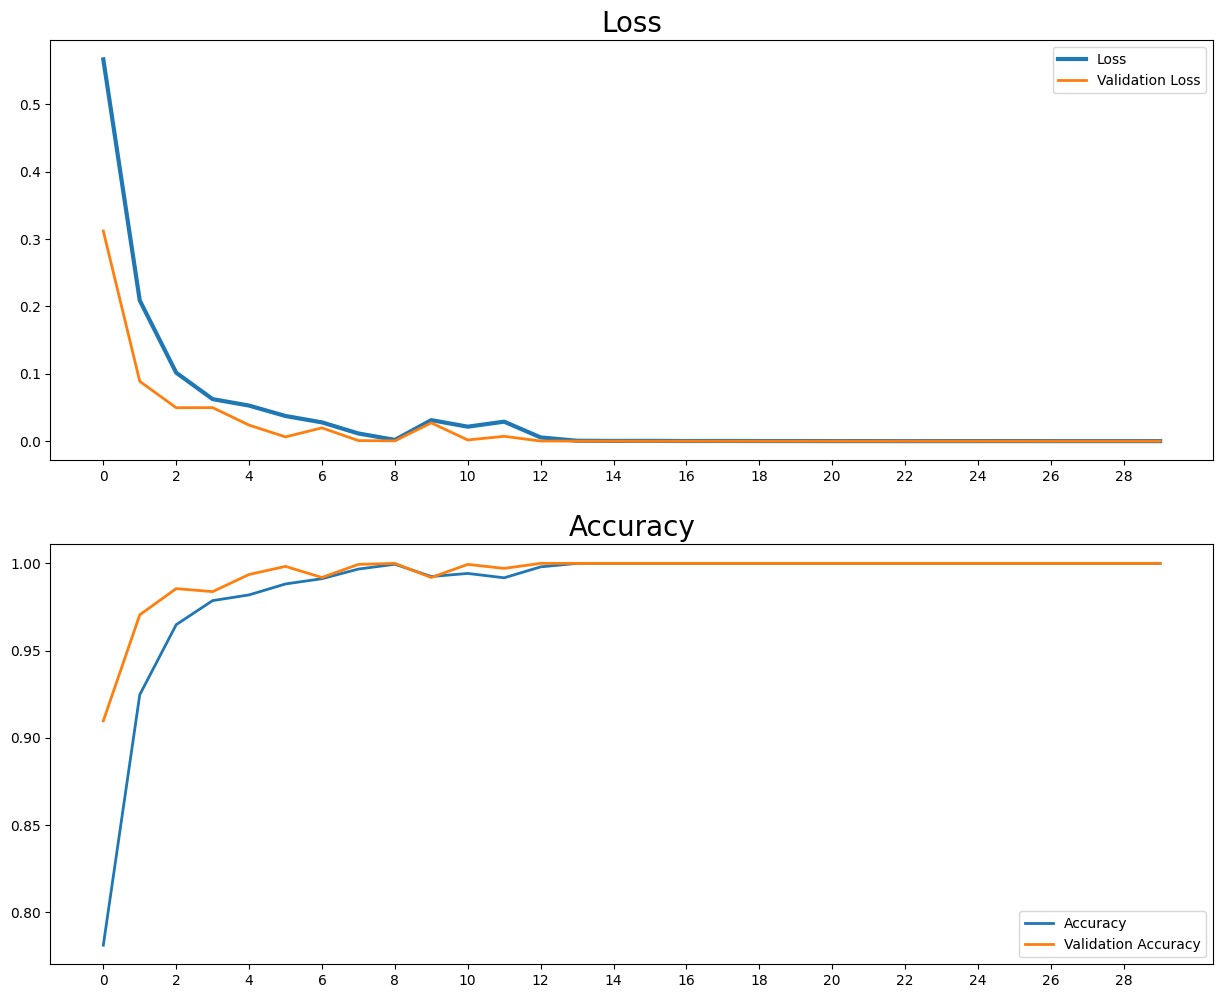

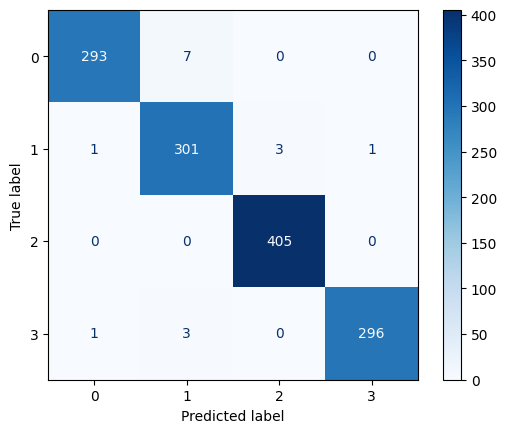

In [34]:
models = [
    (model_name_1, std_b0_nt, history_std_b0_nt, training_time_1),
    (model_name_2, std_b0_tf25, history_std_b0_tf25, training_time_2),
    (model_name_3, std_b0_tf50, history_std_b0_tf50, training_time_3),
    (model_name_4, std_b0_tf75, history_std_b0_tf75, training_time_4),
    (model_name_5, std_b0_tl25, history_std_b0_tl25, training_time_5),
    (model_name_6, std_b0_tl50, history_std_b0_tl50, training_time_6),
    (model_name_7, std_b0_tl75, history_std_b0_tl75, training_time_7),
    (model_name_8, std_b0_ft, history_std_b0_ft, training_time_8)
]

best_model_name, test_loss, test_acc, test_f1score, best_time = best_variant(
    models=models,
    test_ds=test_ds_300,
    output_csv='EfficientNetV2B0 Without Agumentation.csv',
    output_folder='results'
)

config_1 = best_model_name

In [35]:
result(best_model_name, test_loss, test_acc, test_f1score, result_dict, best_time)

# Convert result_dict to a DataFrame
df = pd.DataFrame(result_dict)

# Convert any TensorFlow tensors in the F1Score column to numpy for better readability
df['Test F1Score'] = df['Test F1Score'].apply(lambda x: x.numpy() if hasattr(x, 'numpy') else x)

# Print the DataFrame as a table
print("Result Dictionary Table:")
print(df)

Results saved to results/result.csv
Result Dictionary Table:
                                          Model Name  Test Loss  \
0  EfficientnetV2B0 Without Augmentation Trainabl...   0.061502   

   Test Accuracy  Test F1Score  Training Time  
0       0.987796      0.975689     217.560134  


### EfficientNetV2B3

#### not trainable

In [36]:
model_name_1 = 'EfficientnetV2B3 Without Augmentation Not Trainable'
input_shape = (300,300,3)

std_b3_nt = build_model_not_trainable(EfficientNetV2B3, input_shape=input_shape, num_classes=4)
std_b3_nt, history_std_b3_nt, training_time_1 = train(std_b3_nt, model_name_1, train_ds_300, valid_ds_300, EPOCHS, SAVE_DIRECTORY)

52606240/52606240 [==============================] - 3s 0us/step
Epoch 1/30
245/249 [============================>.] - ETA: 0s - loss: 0.7705 - accuracy: 0.7069 - f1_score: 0.6974

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


249/249 [==============================] - 11s 24ms/step - loss: 0.7672 - accuracy: 0.7081 - f1_score: 0.6988 - val_loss: 0.4186 - val_accuracy: 0.8547 - val_f1_score: 0.8508 - lr: 1.0000e-04
Epoch 2/30
249/249 [==============================] - 5s 20ms/step - loss: 0.4366 - accuracy: 0.8391 - f1_score: 0.8328 - val_loss: 0.3291 - val_accuracy: 0.8750 - val_f1_score: 0.8720 - lr: 1.0000e-04
Epoch 3/30
249/249 [==============================] - 5s 21ms/step - loss: 0.3525 - accuracy: 0.8753 - f1_score: 0.8711 - val_loss: 0.2743 - val_accuracy: 0.9005 - val_f1_score: 0.8970 - lr: 1.0000e-04
Epoch 4/30
249/249 [==============================] - 5s 20ms/step - loss: 0.3182 - accuracy: 0.8896 - f1_score: 0.8862 - val_loss: 0.2450 - val_accuracy: 0.9167 - val_f1_score: 0.9147 - lr: 1.0000e-04
Epoch 5/30
249/249 [==============================] - 5s 20ms/step - loss: 0.2788 - accuracy: 0.8988 - f1_score: 0.8961 - val_loss: 0.2289 - val_accuracy: 0.9178 - val_f1_score: 0.9164 - lr: 1.0000e-04


#### trainable first 25% layers

In [37]:
model_name_2 = 'EfficientnetV2B3 Without Augmentation Trainable First 25% Layer'
input_shape = (300,300,3)

std_b3_tf25 = build_model_trainable_first25(EfficientNetV2B3, input_shape=input_shape, num_classes=4)
std_b3_tf25, history_std_b3_tf25, training_time_2 = train(std_b3_tf25, model_name_2, train_ds_300, valid_ds_300, EPOCHS, SAVE_DIRECTORY)

Epoch 1/30


2024-12-10 13:47:41.325382: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_9/dropout_18/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


249/249 [==============================] - 31s 56ms/step - loss: 0.5083 - accuracy: 0.8080 - f1_score: 0.8038 - val_loss: 0.1855 - val_accuracy: 0.9288 - val_f1_score: 0.9285 - lr: 1.0000e-04
Epoch 2/30
249/249 [==============================] - 12s 48ms/step - loss: 0.1493 - accuracy: 0.9508 - f1_score: 0.9495 - val_loss: 0.0577 - val_accuracy: 0.9792 - val_f1_score: 0.9789 - lr: 1.0000e-04
Epoch 3/30
249/249 [==============================] - 12s 48ms/step - loss: 0.0821 - accuracy: 0.9754 - f1_score: 0.9750 - val_loss: 0.0331 - val_accuracy: 0.9902 - val_f1_score: 0.9900 - lr: 1.0000e-04
Epoch 4/30
249/249 [==============================] - 12s 48ms/step - loss: 0.0445 - accuracy: 0.9852 - f1_score: 0.9849 - val_loss: 0.0253 - val_accuracy: 0.9919 - val_f1_score: 0.9918 - lr: 1.0000e-04
Epoch 5/30
249/249 [==============================] - 11s 46ms/step - loss: 0.0307 - accuracy: 0.9915 - f1_score: 0.9913 - val_loss: 0.0201 - val_accuracy: 0.9907 - val_f1_score: 0.9905 - lr: 1.0000e

#### trainable first 50% layers

In [38]:
model_name_3 = 'EfficientnetV2B3 Without Augmentation Trainable First 50% Layer'
input_shape = (300,300,3)

std_b3_tf50 = build_model_trainable_first50(EfficientNetV2B3, input_shape=input_shape, num_classes=4)
std_b3_tf50, history_std_b3_tf50, training_time_3 = train(std_b3_tf50, model_name_3, train_ds_300, valid_ds_300, EPOCHS, SAVE_DIRECTORY)

Epoch 1/30


2024-12-10 13:53:48.092491: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_10/dropout_20/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


249/249 [==============================] - 24s 49ms/step - loss: 0.5572 - accuracy: 0.7957 - f1_score: 0.7900 - val_loss: 0.2819 - val_accuracy: 0.8924 - val_f1_score: 0.8903 - lr: 1.0000e-04
Epoch 2/30
249/249 [==============================] - 11s 45ms/step - loss: 0.2020 - accuracy: 0.9295 - f1_score: 0.9279 - val_loss: 0.0920 - val_accuracy: 0.9653 - val_f1_score: 0.9649 - lr: 1.0000e-04
Epoch 3/30
249/249 [==============================] - 11s 45ms/step - loss: 0.0876 - accuracy: 0.9706 - f1_score: 0.9701 - val_loss: 0.0321 - val_accuracy: 0.9902 - val_f1_score: 0.9900 - lr: 1.0000e-04
Epoch 4/30
249/249 [==============================] - 11s 45ms/step - loss: 0.0403 - accuracy: 0.9854 - f1_score: 0.9851 - val_loss: 0.0162 - val_accuracy: 0.9959 - val_f1_score: 0.9959 - lr: 1.0000e-04
Epoch 5/30
249/249 [==============================] - 11s 43ms/step - loss: 0.0295 - accuracy: 0.9900 - f1_score: 0.9897 - val_loss: 0.0249 - val_accuracy: 0.9919 - val_f1_score: 0.9918 - lr: 1.0000e

#### trainable first 75% layers

In [39]:
model_name_4 = 'EfficientnetV2B3 Without Augmentation Trainable First 75% Layer'
input_shape = (300,300,3)

std_b3_tf75 = build_model_trainable_first75(EfficientNetV2B3, input_shape=input_shape, num_classes=4)
std_b3_tf75, history_std_b3_tf75, training_time_4 = train(std_b3_tf75, model_name_4, train_ds_300, valid_ds_300, EPOCHS, SAVE_DIRECTORY)

Epoch 1/30


2024-12-10 13:59:31.298000: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_11/dropout_22/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


249/249 [==============================] - 20s 46ms/step - loss: 0.6466 - accuracy: 0.7470 - f1_score: 0.7404 - val_loss: 0.3299 - val_accuracy: 0.8854 - val_f1_score: 0.8836 - lr: 1.0000e-04
Epoch 2/30
249/249 [==============================] - 11s 42ms/step - loss: 0.3200 - accuracy: 0.8808 - f1_score: 0.8770 - val_loss: 0.1718 - val_accuracy: 0.9358 - val_f1_score: 0.9336 - lr: 1.0000e-04
Epoch 3/30
249/249 [==============================] - 11s 42ms/step - loss: 0.2107 - accuracy: 0.9224 - f1_score: 0.9202 - val_loss: 0.1282 - val_accuracy: 0.9473 - val_f1_score: 0.9466 - lr: 1.0000e-04
Epoch 4/30
249/249 [==============================] - 10s 42ms/step - loss: 0.1304 - accuracy: 0.9573 - f1_score: 0.9563 - val_loss: 0.0726 - val_accuracy: 0.9728 - val_f1_score: 0.9724 - lr: 1.0000e-04
Epoch 5/30
249/249 [==============================] - 10s 42ms/step - loss: 0.0830 - accuracy: 0.9704 - f1_score: 0.9695 - val_loss: 0.0715 - val_accuracy: 0.9751 - val_f1_score: 0.9748 - lr: 1.0000e

#### trainable last 25% layers

In [40]:
model_name_5 = 'EfficientnetV2B3 Without Augmentation Trainable Last 25% Layer'
input_shape = (300,300,3)

std_b3_tl25 = build_model_trainable_last25(EfficientNetV2B3, input_shape=input_shape, num_classes=4)
std_b3_tl25, history_std_b3_tl25, training_time_5 = train(std_b3_tl25, model_name_5, train_ds_300, valid_ds_300, EPOCHS, SAVE_DIRECTORY)

Epoch 1/30


2024-12-10 14:04:53.842444: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_12/dropout_24/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


249/249 [==============================] - 15s 29ms/step - loss: 0.4522 - accuracy: 0.8303 - f1_score: 0.8252 - val_loss: 0.1534 - val_accuracy: 0.9433 - val_f1_score: 0.9414 - lr: 1.0000e-04
Epoch 2/30
249/249 [==============================] - 6s 24ms/step - loss: 0.1381 - accuracy: 0.9485 - f1_score: 0.9472 - val_loss: 0.0692 - val_accuracy: 0.9734 - val_f1_score: 0.9729 - lr: 1.0000e-04
Epoch 3/30
249/249 [==============================] - 6s 25ms/step - loss: 0.0799 - accuracy: 0.9734 - f1_score: 0.9727 - val_loss: 0.0406 - val_accuracy: 0.9878 - val_f1_score: 0.9876 - lr: 1.0000e-04
Epoch 4/30
249/249 [==============================] - 6s 24ms/step - loss: 0.0611 - accuracy: 0.9799 - f1_score: 0.9792 - val_loss: 0.0413 - val_accuracy: 0.9844 - val_f1_score: 0.9840 - lr: 1.0000e-04
Epoch 5/30
249/249 [==============================] - 6s 26ms/step - loss: 0.0193 - accuracy: 0.9940 - f1_score: 0.9938 - val_loss: 0.0489 - val_accuracy: 0.9884 - val_f1_score: 0.9883 - lr: 1.0000e-04


#### trainable last 50% layers

In [41]:
model_name_6 = 'EfficientnetV2B3 Without Augmentation Trainable Last 50% Layer'
input_shape = (300,300,3)

std_b3_tl50 = build_model_trainable_last50(EfficientNetV2B3, input_shape=input_shape, num_classes=4)
std_b3_tl50, history_std_b3_tl50, training_time_6 = train(std_b3_tl50, model_name_6, train_ds_300, valid_ds_300, EPOCHS, SAVE_DIRECTORY)

Epoch 1/30


2024-12-10 14:08:07.197185: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_13/dropout_26/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


249/249 [==============================] - 20s 35ms/step - loss: 0.4060 - accuracy: 0.8522 - f1_score: 0.8485 - val_loss: 0.1407 - val_accuracy: 0.9485 - val_f1_score: 0.9479 - lr: 1.0000e-04
Epoch 2/30
249/249 [==============================] - 8s 31ms/step - loss: 0.1214 - accuracy: 0.9586 - f1_score: 0.9575 - val_loss: 0.0669 - val_accuracy: 0.9809 - val_f1_score: 0.9807 - lr: 1.0000e-04
Epoch 3/30
249/249 [==============================] - 8s 31ms/step - loss: 0.0587 - accuracy: 0.9809 - f1_score: 0.9803 - val_loss: 0.0247 - val_accuracy: 0.9913 - val_f1_score: 0.9912 - lr: 1.0000e-04
Epoch 4/30
249/249 [==============================] - 8s 31ms/step - loss: 0.0523 - accuracy: 0.9832 - f1_score: 0.9826 - val_loss: 0.0159 - val_accuracy: 0.9948 - val_f1_score: 0.9947 - lr: 1.0000e-04
Epoch 5/30
249/249 [==============================] - 7s 29ms/step - loss: 0.0430 - accuracy: 0.9864 - f1_score: 0.9862 - val_loss: 0.0333 - val_accuracy: 0.9919 - val_f1_score: 0.9917 - lr: 1.0000e-04


#### trainable last 75% layers

In [42]:
model_name_7 = 'EfficientnetV2B3 Without Augmentation Trainable Last 75% Layer'
input_shape = (300,300,3)

std_b3_tl75 = build_model_trainable_last75(EfficientNetV2B3, input_shape=input_shape, num_classes=4)
std_b3_tl75, history_std_b3_tl75, training_time_7 = train(std_b3_tl75, model_name_7, train_ds_300, valid_ds_300, EPOCHS, SAVE_DIRECTORY)

Epoch 1/30


2024-12-10 14:12:05.671904: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_14/dropout_28/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


249/249 [==============================] - 27s 42ms/step - loss: 0.4662 - accuracy: 0.8251 - f1_score: 0.8200 - val_loss: 0.1583 - val_accuracy: 0.9502 - val_f1_score: 0.9493 - lr: 1.0000e-04
Epoch 2/30
249/249 [==============================] - 10s 38ms/step - loss: 0.1459 - accuracy: 0.9478 - f1_score: 0.9465 - val_loss: 0.1085 - val_accuracy: 0.9664 - val_f1_score: 0.9661 - lr: 1.0000e-04
Epoch 3/30
249/249 [==============================] - 10s 38ms/step - loss: 0.0862 - accuracy: 0.9714 - f1_score: 0.9705 - val_loss: 0.0321 - val_accuracy: 0.9913 - val_f1_score: 0.9912 - lr: 1.0000e-04
Epoch 4/30
249/249 [==============================] - 10s 38ms/step - loss: 0.0377 - accuracy: 0.9897 - f1_score: 0.9896 - val_loss: 0.0171 - val_accuracy: 0.9925 - val_f1_score: 0.9924 - lr: 1.0000e-04
Epoch 5/30
249/249 [==============================] - 10s 39ms/step - loss: 0.0127 - accuracy: 0.9967 - f1_score: 0.9966 - val_loss: 0.0074 - val_accuracy: 0.9988 - val_f1_score: 0.9988 - lr: 1.0000e

#### full trainable

In [43]:
model_name_8 = 'EfficientnetV2B3 Without Augmentation Trainable Full Trainable'
input_shape = (300,300,3)

std_b3_ft = build_model_full_trainable(EfficientNetV2B3, input_shape=input_shape, num_classes=4)
std_b3_ft, history_std_b3_ft, training_time_8 = train(std_b3_ft, model_name_8, train_ds_300, valid_ds_300, EPOCHS, SAVE_DIRECTORY)

Epoch 1/30


2024-12-10 14:17:04.573105: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_15/dropout_30/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


249/249 [==============================] - 36s 57ms/step - loss: 0.4271 - accuracy: 0.8379 - f1_score: 0.8332 - val_loss: 0.1572 - val_accuracy: 0.9531 - val_f1_score: 0.9525 - lr: 1.0000e-04
Epoch 2/30
249/249 [==============================] - 12s 50ms/step - loss: 0.1385 - accuracy: 0.9566 - f1_score: 0.9555 - val_loss: 0.1497 - val_accuracy: 0.9479 - val_f1_score: 0.9468 - lr: 1.0000e-04
Epoch 3/30
249/249 [==============================] - 13s 54ms/step - loss: 0.0666 - accuracy: 0.9804 - f1_score: 0.9802 - val_loss: 0.0172 - val_accuracy: 0.9954 - val_f1_score: 0.9953 - lr: 1.0000e-04
Epoch 4/30
249/249 [==============================] - 13s 51ms/step - loss: 0.0547 - accuracy: 0.9827 - f1_score: 0.9823 - val_loss: 0.0186 - val_accuracy: 0.9913 - val_f1_score: 0.9911 - lr: 1.0000e-04
Epoch 5/30
249/249 [==============================] - 13s 51ms/step - loss: 0.0536 - accuracy: 0.9849 - f1_score: 0.9846 - val_loss: 0.0161 - val_accuracy: 0.9942 - val_f1_score: 0.9942 - lr: 1.0000e

Model comparison table saved to results/EfficientNetV2B3 Without Agumentation.csv
Model Comparison Table:
                                          Model Name          Loss  Accuracy  \
0  EfficientnetV2B3 Without Augmentation Trainabl...  5.084845e-06  1.000000   
1  EfficientnetV2B3 Without Augmentation Trainabl...  8.324351e-06  1.000000   
2  EfficientnetV2B3 Without Augmentation Trainabl...  4.056099e-05  1.000000   
3  EfficientnetV2B3 Without Augmentation Trainabl...  1.288745e-06  1.000000   
4  EfficientnetV2B3 Without Augmentation Trainabl...  2.935031e-06  1.000000   
5  EfficientnetV2B3 Without Augmentation Trainabl...  5.761646e-07  1.000000   
6  EfficientnetV2B3 Without Augmentation Trainabl...  2.890085e-06  1.000000   
7  EfficientnetV2B3 Without Augmentation Not Trai...  2.124686e-02  0.995949   

   F1 Score  Training Time  
0  1.000000     367.200194  
1  1.000000     342.200054  
2  1.000000     322.371743  
3  1.000000     190.326855  
4  1.000000     235.169111  

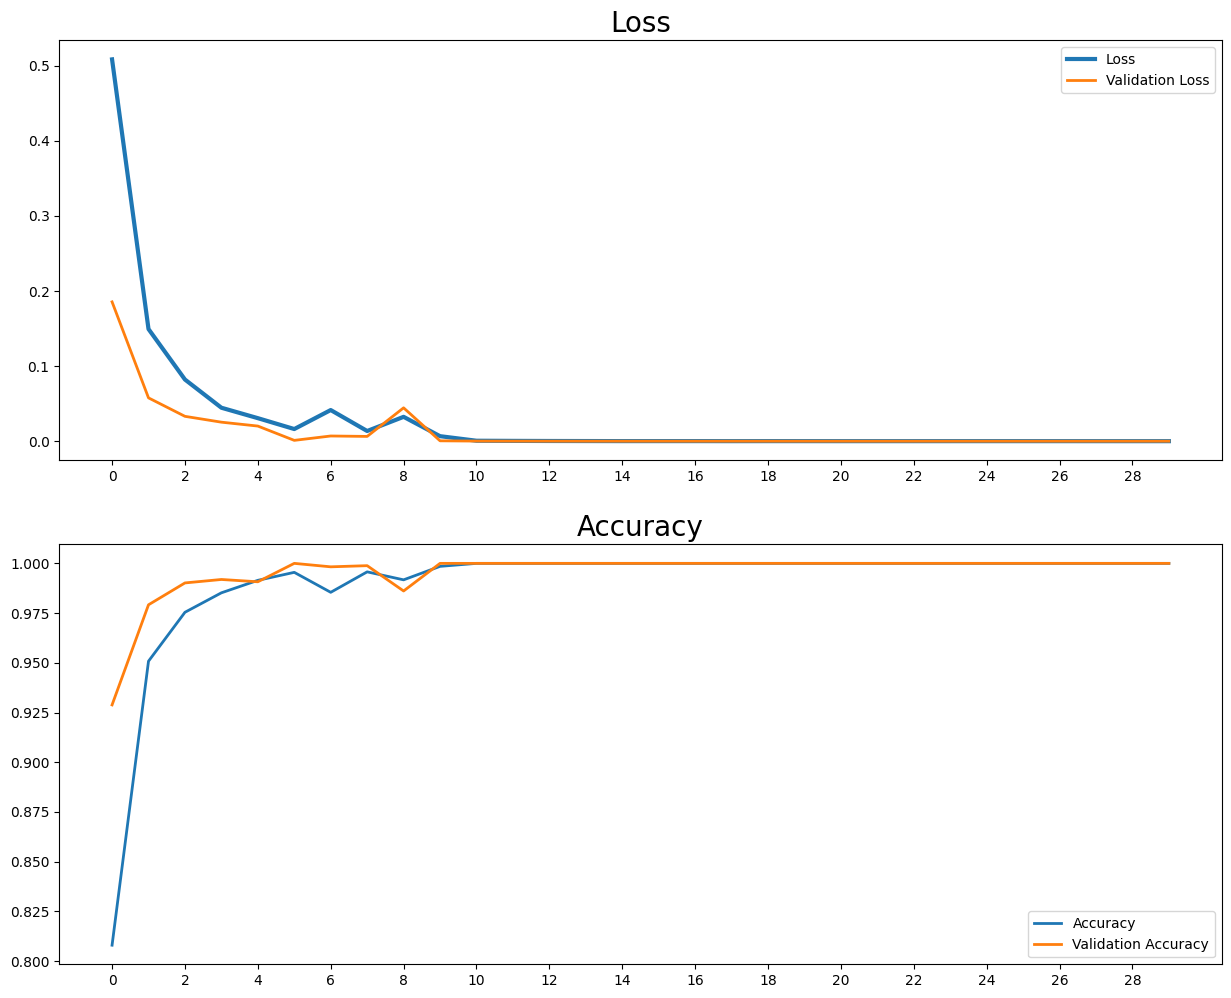

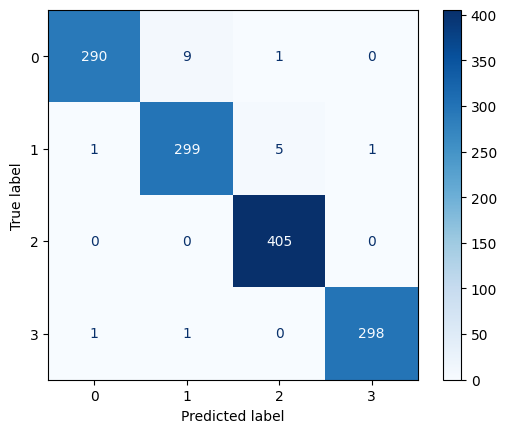

In [44]:
models = [
    (model_name_1, std_b3_nt, history_std_b3_nt, training_time_1),
    (model_name_2, std_b3_tf25, history_std_b3_tf25, training_time_2),
    (model_name_3, std_b3_tf50, history_std_b3_tf50, training_time_3),
    (model_name_4, std_b3_tf75, history_std_b3_tf75, training_time_4),
    (model_name_5, std_b3_tl25, history_std_b3_tl25, training_time_5),
    (model_name_6, std_b3_tl50, history_std_b3_tl50, training_time_6),
    (model_name_7, std_b3_tl75, history_std_b3_tl75, training_time_7),
    (model_name_8, std_b3_ft, history_std_b3_ft, training_time_8)
]

best_model_name, test_loss, test_acc, test_f1score, best_time = best_variant(
    models=models,
    test_ds=test_ds_300,
    output_csv='EfficientNetV2B3 Without Agumentation.csv',
    output_folder='results'
)

config_2 = best_model_name

In [45]:
result(best_model_name, test_loss, test_acc, test_f1score, result_dict, best_time)

# Convert result_dict to a DataFrame
df = pd.DataFrame(result_dict)

# Convert any TensorFlow tensors in the F1Score column to numpy for better readability
df['Test F1Score'] = df['Test F1Score'].apply(lambda x: x.numpy() if hasattr(x, 'numpy') else x)

# Print the DataFrame as a table
print("Result Dictionary Table:")
print(df)

Results saved to results/result.csv
Result Dictionary Table:
                                          Model Name  Test Loss  \
0  EfficientnetV2B0 Without Augmentation Trainabl...   0.061502   
1  EfficientnetV2B3 Without Augmentation Trainabl...   0.076138   

   Test Accuracy  Test F1Score  Training Time  
0       0.987796      0.975689     217.560134  
1       0.985507      0.972358     367.200194  


### EfficientNetV2M

#### not trainable

In [46]:
model_name_1 = 'EfficientnetV2M Withouth Augmentation Not Trainable'
input_shape = (300,300,3)

std_m_nt = build_model_not_trainable(EfficientNetV2M, input_shape=input_shape, num_classes=4)
std_m_nt, history_std_m_nt, training_time_1 = train(std_m_nt, model_name_1, train_ds_300, valid_ds_300, EPOCHS, SAVE_DIRECTORY)

214201816/214201816 [==============================] - 8s 0us/step
Epoch 1/30
249/249 [==============================] - ETA: 0s - loss: 0.9200 - accuracy: 0.6265 - f1_score: 0.6077

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


249/249 [==============================] - 18s 48ms/step - loss: 0.9200 - accuracy: 0.6265 - f1_score: 0.6077 - val_loss: 0.5895 - val_accuracy: 0.7801 - val_f1_score: 0.7763 - lr: 1.0000e-04
Epoch 2/30
249/249 [==============================] - 10s 41ms/step - loss: 0.5640 - accuracy: 0.7754 - f1_score: 0.7665 - val_loss: 0.4454 - val_accuracy: 0.8397 - val_f1_score: 0.8379 - lr: 1.0000e-04
Epoch 3/30
249/249 [==============================] - 10s 42ms/step - loss: 0.4512 - accuracy: 0.8333 - f1_score: 0.8268 - val_loss: 0.3710 - val_accuracy: 0.8657 - val_f1_score: 0.8643 - lr: 1.0000e-04
Epoch 4/30
249/249 [==============================] - 10s 41ms/step - loss: 0.3964 - accuracy: 0.8584 - f1_score: 0.8534 - val_loss: 0.3263 - val_accuracy: 0.8750 - val_f1_score: 0.8737 - lr: 1.0000e-04
Epoch 5/30
249/249 [==============================] - 10s 40ms/step - loss: 0.3591 - accuracy: 0.8670 - f1_score: 0.8627 - val_loss: 0.3185 - val_accuracy: 0.8837 - val_f1_score: 0.8819 - lr: 1.0000e

#### trainable first 25% layers

In [47]:
model_name_2 = 'EfficientnetV2M Without Augmentation Trainable First 25% Layer'
input_shape = (300,300,3)

std_m_tf25 = build_model_trainable_first25(EfficientNetV2M, input_shape=input_shape, num_classes=4)
std_m_tf25, history_std_m_tf25, training_time_2 = train(std_m_tf25, model_name_2, train_ds_300, valid_ds_300, EPOCHS, SAVE_DIRECTORY)

Epoch 1/30


2024-12-10 14:29:51.855549: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_17/dropout_34/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


249/249 [==============================] - 63s 116ms/step - loss: 0.5618 - accuracy: 0.7927 - f1_score: 0.7888 - val_loss: 0.1965 - val_accuracy: 0.9363 - val_f1_score: 0.9358 - lr: 1.0000e-04
Epoch 2/30
249/249 [==============================] - 27s 110ms/step - loss: 0.1877 - accuracy: 0.9413 - f1_score: 0.9398 - val_loss: 0.1689 - val_accuracy: 0.9485 - val_f1_score: 0.9478 - lr: 1.0000e-04
Epoch 3/30
249/249 [==============================] - 27s 108ms/step - loss: 0.1133 - accuracy: 0.9608 - f1_score: 0.9598 - val_loss: 0.1601 - val_accuracy: 0.9491 - val_f1_score: 0.9489 - lr: 1.0000e-04
Epoch 4/30
249/249 [==============================] - 27s 109ms/step - loss: 0.0442 - accuracy: 0.9872 - f1_score: 0.9869 - val_loss: 0.0535 - val_accuracy: 0.9861 - val_f1_score: 0.9860 - lr: 1.0000e-04
Epoch 5/30
249/249 [==============================] - 26s 104ms/step - loss: 0.0458 - accuracy: 0.9867 - f1_score: 0.9864 - val_loss: 0.0505 - val_accuracy: 0.9861 - val_f1_score: 0.9860 - lr: 1.

#### trainable first 50% layers

In [48]:
model_name_3 = 'EfficientnetV2M Without Augmentation Trainable First 50% Layer'
input_shape = (300,300,3)

std_m_tf50 = build_model_trainable_first50(EfficientNetV2M, input_shape=input_shape, num_classes=4)
std_m_tf50, history_std_m_tf50, training_time_3 = train(std_m_tf50, model_name_3, train_ds_300, valid_ds_300, EPOCHS, SAVE_DIRECTORY)

Epoch 1/30


2024-12-10 14:43:22.936971: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_18/dropout_36/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


249/249 [==============================] - 49s 108ms/step - loss: 0.6030 - accuracy: 0.7701 - f1_score: 0.7622 - val_loss: 0.2444 - val_accuracy: 0.9062 - val_f1_score: 0.9067 - lr: 1.0000e-04
Epoch 2/30
249/249 [==============================] - 25s 101ms/step - loss: 0.2113 - accuracy: 0.9295 - f1_score: 0.9277 - val_loss: 0.1789 - val_accuracy: 0.9253 - val_f1_score: 0.9224 - lr: 1.0000e-04
Epoch 3/30
249/249 [==============================] - 25s 100ms/step - loss: 0.0775 - accuracy: 0.9744 - f1_score: 0.9737 - val_loss: 0.0449 - val_accuracy: 0.9838 - val_f1_score: 0.9836 - lr: 1.0000e-04
Epoch 4/30
249/249 [==============================] - 25s 101ms/step - loss: 0.0465 - accuracy: 0.9862 - f1_score: 0.9859 - val_loss: 0.0174 - val_accuracy: 0.9931 - val_f1_score: 0.9929 - lr: 1.0000e-04
Epoch 5/30
249/249 [==============================] - 24s 98ms/step - loss: 0.0265 - accuracy: 0.9920 - f1_score: 0.9919 - val_loss: 0.0363 - val_accuracy: 0.9867 - val_f1_score: 0.9866 - lr: 1.0

#### trainable first 75% layers

In [49]:
model_name_4 = 'EfficientnetV2M Without Augmentation Trainable First 75% Layer'
input_shape = (300,300,3)

std_m_tf75 = build_model_trainable_first75(EfficientNetV2M, input_shape=input_shape, num_classes=4)
std_m_tf75, history_std_m_tf75, training_time_4 = train(std_m_tf75, model_name_4, train_ds_300, valid_ds_300, EPOCHS, SAVE_DIRECTORY)

Epoch 1/30


2024-12-10 14:56:05.938081: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_19/dropout_38/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


249/249 [==============================] - 39s 101ms/step - loss: 0.6871 - accuracy: 0.7455 - f1_score: 0.7386 - val_loss: 0.3129 - val_accuracy: 0.8889 - val_f1_score: 0.8873 - lr: 1.0000e-04
Epoch 2/30
249/249 [==============================] - 24s 95ms/step - loss: 0.3191 - accuracy: 0.8850 - f1_score: 0.8817 - val_loss: 0.2099 - val_accuracy: 0.9230 - val_f1_score: 0.9216 - lr: 1.0000e-04
Epoch 3/30
249/249 [==============================] - 24s 95ms/step - loss: 0.1887 - accuracy: 0.9347 - f1_score: 0.9327 - val_loss: 0.0856 - val_accuracy: 0.9728 - val_f1_score: 0.9723 - lr: 1.0000e-04
Epoch 4/30
249/249 [==============================] - 24s 95ms/step - loss: 0.1016 - accuracy: 0.9691 - f1_score: 0.9683 - val_loss: 0.0414 - val_accuracy: 0.9861 - val_f1_score: 0.9860 - lr: 1.0000e-04
Epoch 5/30
249/249 [==============================] - 24s 95ms/step - loss: 0.0633 - accuracy: 0.9804 - f1_score: 0.9798 - val_loss: 0.0303 - val_accuracy: 0.9907 - val_f1_score: 0.9906 - lr: 1.0000

#### trainable last 25% layers

In [50]:
model_name_5 = 'EfficientnetV2M Without Augmentation Trainable Last 25% Layer'
input_shape = (300,300,3)

std_m_tl25 = build_model_trainable_last25(EfficientNetV2M, input_shape=input_shape, num_classes=4)
std_m_tl25, history_std_m_tl25, training_time_5 = train(std_m_tl25, model_name_5, train_ds_300, valid_ds_300, EPOCHS, SAVE_DIRECTORY)

Epoch 1/30


2024-12-10 15:08:06.784938: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_20/dropout_40/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


249/249 [==============================] - 31s 62ms/step - loss: 0.4195 - accuracy: 0.8396 - f1_score: 0.8363 - val_loss: 0.1618 - val_accuracy: 0.9468 - val_f1_score: 0.9460 - lr: 1.0000e-04
Epoch 2/30
249/249 [==============================] - 14s 54ms/step - loss: 0.1664 - accuracy: 0.9458 - f1_score: 0.9442 - val_loss: 0.0579 - val_accuracy: 0.9780 - val_f1_score: 0.9775 - lr: 1.0000e-04
Epoch 3/30
249/249 [==============================] - 13s 52ms/step - loss: 0.0906 - accuracy: 0.9726 - f1_score: 0.9719 - val_loss: 0.0652 - val_accuracy: 0.9740 - val_f1_score: 0.9734 - lr: 1.0000e-04
Epoch 4/30
249/249 [==============================] - 14s 56ms/step - loss: 0.0582 - accuracy: 0.9814 - f1_score: 0.9807 - val_loss: 0.0325 - val_accuracy: 0.9896 - val_f1_score: 0.9893 - lr: 1.0000e-04
Epoch 5/30
249/249 [==============================] - 13s 52ms/step - loss: 0.0334 - accuracy: 0.9905 - f1_score: 0.9901 - val_loss: 0.0852 - val_accuracy: 0.9630 - val_f1_score: 0.9618 - lr: 1.0000e

#### trainable last 50% layers

In [51]:
model_name_6 = 'EfficientnetV2M Without Augmentation Trainable Last 50% Layer'
input_shape = (300,300,3)

std_m_tl50 = build_model_trainable_last50(EfficientNetV2M, input_shape=input_shape, num_classes=4)
std_m_tl50, history_std_m_tl50, training_time_6 = train(std_m_tl50, model_name_6, train_ds_300, valid_ds_300, EPOCHS, SAVE_DIRECTORY)

Epoch 1/30


2024-12-10 15:15:03.489184: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_21/dropout_42/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


249/249 [==============================] - 43s 74ms/step - loss: 0.4849 - accuracy: 0.8143 - f1_score: 0.8101 - val_loss: 0.1440 - val_accuracy: 0.9497 - val_f1_score: 0.9493 - lr: 1.0000e-04
Epoch 2/30
249/249 [==============================] - 17s 68ms/step - loss: 0.2084 - accuracy: 0.9332 - f1_score: 0.9313 - val_loss: 0.0738 - val_accuracy: 0.9716 - val_f1_score: 0.9712 - lr: 1.0000e-04
Epoch 3/30
249/249 [==============================] - 17s 68ms/step - loss: 0.0837 - accuracy: 0.9759 - f1_score: 0.9751 - val_loss: 0.0325 - val_accuracy: 0.9913 - val_f1_score: 0.9912 - lr: 1.0000e-04
Epoch 4/30
249/249 [==============================] - 16s 63ms/step - loss: 0.0850 - accuracy: 0.9739 - f1_score: 0.9732 - val_loss: 0.0400 - val_accuracy: 0.9913 - val_f1_score: 0.9913 - lr: 1.0000e-04
Epoch 5/30
249/249 [==============================] - 16s 63ms/step - loss: 0.0426 - accuracy: 0.9902 - f1_score: 0.9899 - val_loss: 0.0604 - val_accuracy: 0.9786 - val_f1_score: 0.9783 - lr: 1.0000e

#### trainable last 75% layers

In [52]:
model_name_7 = 'EfficientnetV2M Without Augmentation Trainable Last 75% Layer'
input_shape = (300,300,3)

std_m_tl75 = build_model_trainable_last75(EfficientNetV2M, input_shape=input_shape, num_classes=4)
std_m_tl75, history_std_m_tl75, training_time_7 = train(std_m_tl75, model_name_7, train_ds_300, valid_ds_300, EPOCHS, SAVE_DIRECTORY)

Epoch 1/30


2024-12-10 15:23:31.905606: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_22/dropout_44/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


249/249 [==============================] - 54s 93ms/step - loss: 0.5510 - accuracy: 0.7922 - f1_score: 0.7868 - val_loss: 0.5357 - val_accuracy: 0.7743 - val_f1_score: 0.7400 - lr: 1.0000e-04
Epoch 2/30
249/249 [==============================] - 22s 86ms/step - loss: 0.2158 - accuracy: 0.9312 - f1_score: 0.9292 - val_loss: 0.0917 - val_accuracy: 0.9641 - val_f1_score: 0.9631 - lr: 1.0000e-04
Epoch 3/30
249/249 [==============================] - 22s 87ms/step - loss: 0.1442 - accuracy: 0.9636 - f1_score: 0.9631 - val_loss: 0.0878 - val_accuracy: 0.9734 - val_f1_score: 0.9731 - lr: 1.0000e-04
Epoch 4/30
249/249 [==============================] - 22s 86ms/step - loss: 0.0645 - accuracy: 0.9812 - f1_score: 0.9807 - val_loss: 0.0596 - val_accuracy: 0.9850 - val_f1_score: 0.9850 - lr: 1.0000e-04
Epoch 5/30
249/249 [==============================] - 22s 87ms/step - loss: 0.0377 - accuracy: 0.9902 - f1_score: 0.9899 - val_loss: 0.0190 - val_accuracy: 0.9948 - val_f1_score: 0.9947 - lr: 1.0000e

#### full trainable

In [53]:
model_name_8 = 'EfficientnetV2M Without Augmentation Full Trainable'
input_shape = (300,300,3)

std_m_ft = build_model_full_trainable(EfficientNetV2M, input_shape=input_shape, num_classes=4)
std_m_ft, history_std_m_ft, training_time_8 = train(std_m_ft, model_name_8, train_ds_300, valid_ds_300, EPOCHS, SAVE_DIRECTORY)

Epoch 1/30


2024-12-10 15:34:36.115659: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_23/dropout_46/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


249/249 [==============================] - 73s 136ms/step - loss: 0.6058 - accuracy: 0.7653 - f1_score: 0.7596 - val_loss: 0.1625 - val_accuracy: 0.9444 - val_f1_score: 0.9433 - lr: 1.0000e-04
Epoch 2/30
249/249 [==============================] - 29s 115ms/step - loss: 0.1867 - accuracy: 0.9448 - f1_score: 0.9438 - val_loss: 0.1228 - val_accuracy: 0.9676 - val_f1_score: 0.9672 - lr: 1.0000e-04
Epoch 3/30
249/249 [==============================] - 28s 114ms/step - loss: 0.1275 - accuracy: 0.9623 - f1_score: 0.9617 - val_loss: 0.0491 - val_accuracy: 0.9873 - val_f1_score: 0.9871 - lr: 1.0000e-04
Epoch 4/30
249/249 [==============================] - 27s 108ms/step - loss: 0.1064 - accuracy: 0.9709 - f1_score: 0.9703 - val_loss: 0.0813 - val_accuracy: 0.9705 - val_f1_score: 0.9699 - lr: 1.0000e-04
Epoch 5/30
249/249 [==============================] - 27s 109ms/step - loss: 0.0797 - accuracy: 0.9787 - f1_score: 0.9783 - val_loss: 0.0423 - val_accuracy: 0.9838 - val_f1_score: 0.9835 - lr: 1.

Model comparison table saved to results/EfficientNetV2M Without Agumentation.csv
Model Comparison Table:
                                          Model Name          Loss  Accuracy  \
0  EfficientnetV2M Without Augmentation Trainable...  4.036297e-06  1.000000   
1  EfficientnetV2M Without Augmentation Trainable...  2.353912e-05  1.000000   
2  EfficientnetV2M Without Augmentation Trainable...  1.581355e-05  1.000000   
3  EfficientnetV2M Without Augmentation Trainable...  5.016361e-07  1.000000   
4  EfficientnetV2M Without Augmentation Trainable...  1.739419e-06  1.000000   
5  EfficientnetV2M Without Augmentation Trainable...  3.238851e-07  1.000000   
6  EfficientnetV2M Without Augmentation Full Trai...  2.582521e-06  1.000000   
7  EfficientnetV2M Withouth Augmentation Not Trai...  5.102126e-02  0.984375   

   F1 Score  Training Time  
0  1.000000     814.237767  
1  1.000000     761.333990  
2  1.000000     716.725759  
3  1.000000     408.728959  
4  1.000000     504.765449  


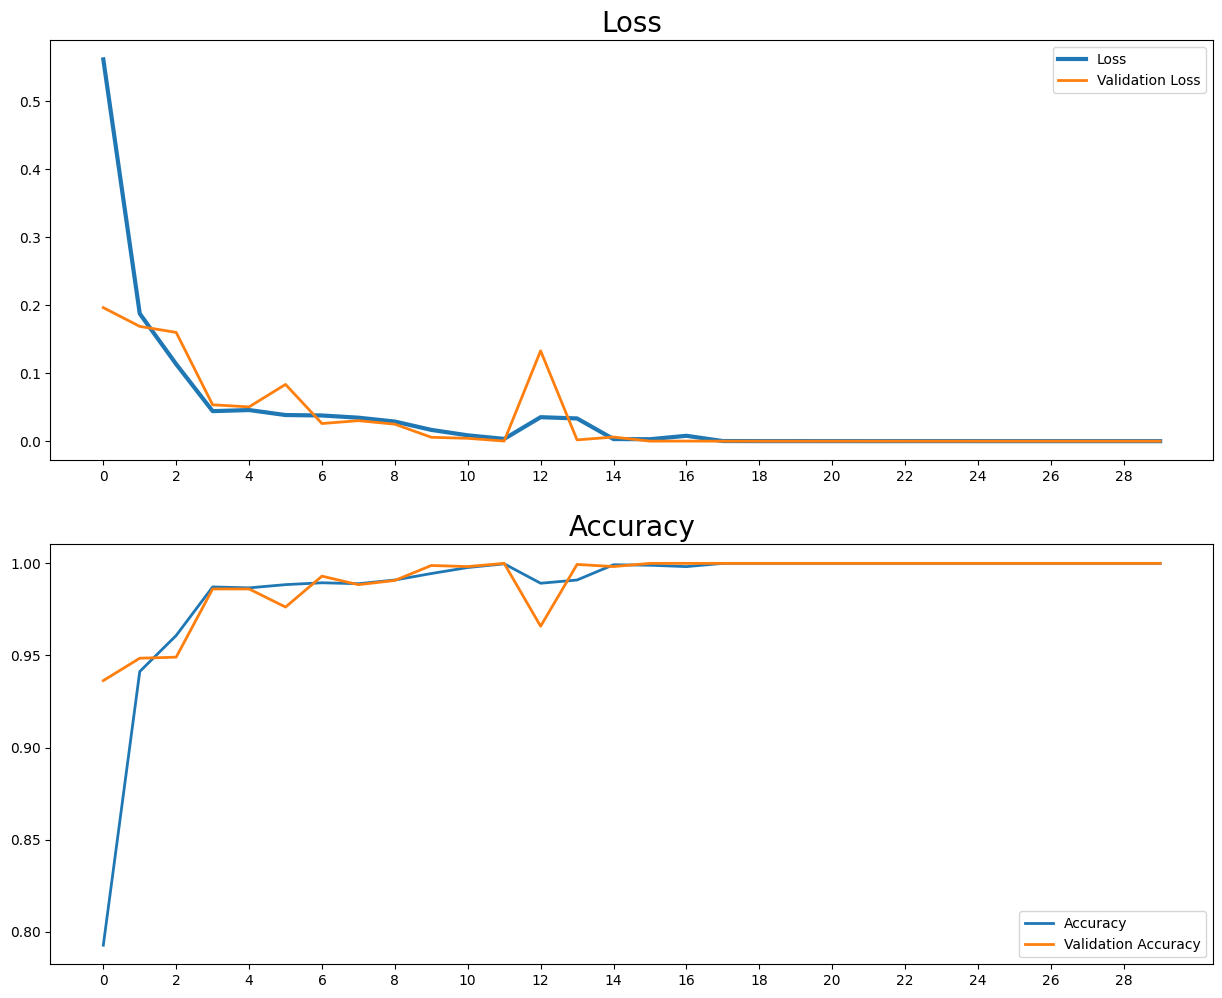

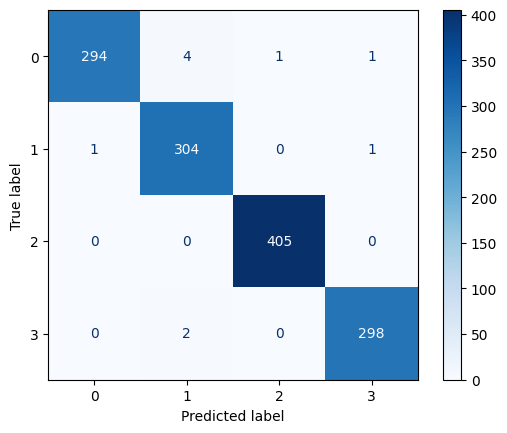

In [54]:
models = [
    (model_name_1, std_m_nt, history_std_m_nt, training_time_1),
    (model_name_2, std_m_tf25, history_std_m_tf25, training_time_2),
    (model_name_3, std_m_tf50, history_std_m_tf50, training_time_3),
    (model_name_4, std_m_tf75, history_std_m_tf75, training_time_4),
    (model_name_5, std_m_tl25, history_std_m_tl25, training_time_5),
    (model_name_6, std_m_tl50, history_std_m_tl50, training_time_6),
    (model_name_7, std_m_tl75, history_std_m_tl75, training_time_7),
    (model_name_8, std_m_ft, history_std_m_ft, training_time_8)
]

best_model_name, test_loss, test_acc, test_f1score, best_time = best_variant(
    models=models,
    test_ds=test_ds_300,
    output_csv='EfficientNetV2M Without Agumentation.csv',
    output_folder='results'
)

config_3 = best_model_name

In [55]:
result(best_model_name, test_loss, test_acc, test_f1score, result_dict, best_time)

# Convert result_dict to a DataFrame
df = pd.DataFrame(result_dict)

# Convert any TensorFlow tensors in the F1Score column to numpy for better readability
df['Test F1Score'] = df['Test F1Score'].apply(lambda x: x.numpy() if hasattr(x, 'numpy') else x)

# Print the DataFrame as a table
print("Result Dictionary Table:")
print(df)

Results saved to results/result.csv
Result Dictionary Table:
                                          Model Name  Test Loss  \
0  EfficientnetV2B0 Without Augmentation Trainabl...   0.061502   
1  EfficientnetV2B3 Without Augmentation Trainabl...   0.076138   
2  EfficientnetV2M Without Augmentation Trainable...   0.072342   

   Test Accuracy  Test F1Score  Training Time  
0       0.987796      0.975689     217.560134  
1       0.985507      0.972358     367.200194  
2       0.992372      0.987013     814.237767  


## Augmentation

In [25]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.25),
    tf.keras.layers.RandomTranslation(0.15, 0.15),
    # tf.keras.layers.RandomZoom(0.2, 0.2),
    # tf.keras.layers.RandomBrightness(0.2)
])

In [26]:
def augmentation_train(image, label):
    image = preprocess_input(image)
    image = data_augmentation(image)
    return image, label

def preprocess_val(image, label):
    image = preprocess_input(image)
    return image, label

In [27]:
train_aug_300 = train_ds_300.map(augmentation_train, num_parallel_calls=tf.data.AUTOTUNE)
valid_aug_300 = valid_ds_300.map(preprocess_val, num_parallel_calls=tf.data.AUTOTUNE)

train_aug_300 = train_aug_300.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_aug_300 = valid_aug_300.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [28]:
train_aug_300 = train_aug_300.concatenate(train_ds_300)

### EfficientNetV2B0

In [29]:
model_name_1 = "EfficientnetV2B0 with Augmentation Full Trainable"
input_shape = (300,300,3)

aug_b0 = build_model_full_trainable(EfficientNetV2B0, input_shape=input_shape, num_classes=4)
aug_b0, history_aug_b0, training_time_1 = train(aug_b0, model_name_1, train_aug_300, valid_aug_300, EPOCHS, SAVE_DIRECTORY)

24274472/24274472 [==============================] - 2s 0us/step
Epoch 1/30


2024-12-28 02:52:54.624048: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-12-28 02:52:59.849411: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8905
2024-12-28 02:52:59.971287: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-12-28 02:53:00.760400: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x78af6cae1330 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-28 02:53:00.760415: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-12-28 02:53:00.764350: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set 

498/498 [==============================] - ETA: 0s - loss: 0.3858 - accuracy: 0.8581 - f1_score: 0.8550

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


498/498 [==============================] - 34s 27ms/step - loss: 0.3858 - accuracy: 0.8581 - f1_score: 0.8550 - val_loss: 0.0860 - val_accuracy: 0.9705 - val_f1_score: 0.9701 - lr: 1.0000e-04
Epoch 2/30
498/498 [==============================] - 13s 25ms/step - loss: 0.1087 - accuracy: 0.9631 - f1_score: 0.9625 - val_loss: 0.0380 - val_accuracy: 0.9884 - val_f1_score: 0.9883 - lr: 1.0000e-04
Epoch 3/30
498/498 [==============================] - 13s 26ms/step - loss: 0.0674 - accuracy: 0.9767 - f1_score: 0.9763 - val_loss: 0.0126 - val_accuracy: 0.9959 - val_f1_score: 0.9959 - lr: 1.0000e-04
Epoch 4/30
498/498 [==============================] - 12s 25ms/step - loss: 0.0507 - accuracy: 0.9849 - f1_score: 0.9848 - val_loss: 0.0128 - val_accuracy: 0.9959 - val_f1_score: 0.9960 - lr: 1.0000e-04
Epoch 5/30
498/498 [==============================] - 13s 26ms/step - loss: 0.0466 - accuracy: 0.9874 - f1_score: 0.9873 - val_loss: 0.0093 - val_accuracy: 0.9977 - val_f1_score: 0.9977 - lr: 1.0000e

Model comparison table saved to results/EfficientNetV2B0 With Agumentation.csv
Model Comparison Table:
                                          Model Name          Loss  Accuracy  \
0  EfficientnetV2B0 with Augmentation Full Trainable  9.637273e-07       1.0   

   F1 Score  Training Time  
0       1.0     396.749113  
Accuracy and Loss plot saved to results/EfficientnetV2B0 with Augmentation Full Trainable/EfficientnetV2B0 with Augmentation Full Trainable_acc_loss_plot.png
1/1 [==============================] - 0s 16ms/step
Confusion Matrix plot saved to results/EfficientnetV2B0 with Augmentation Full Trainable/EfficientnetV2B0 with Augmentation Full Trainable_confusion_matrix.png
Classification Report
              precision    recall  f1-score   support

           0    0.99663   0.98667   0.99162       300
           1    0.98065   0.99346   0.98701       306
           2    0.99509   1.00000   0.99754       405
           3    0.99663   0.98667   0.99162       300

    accuracy  

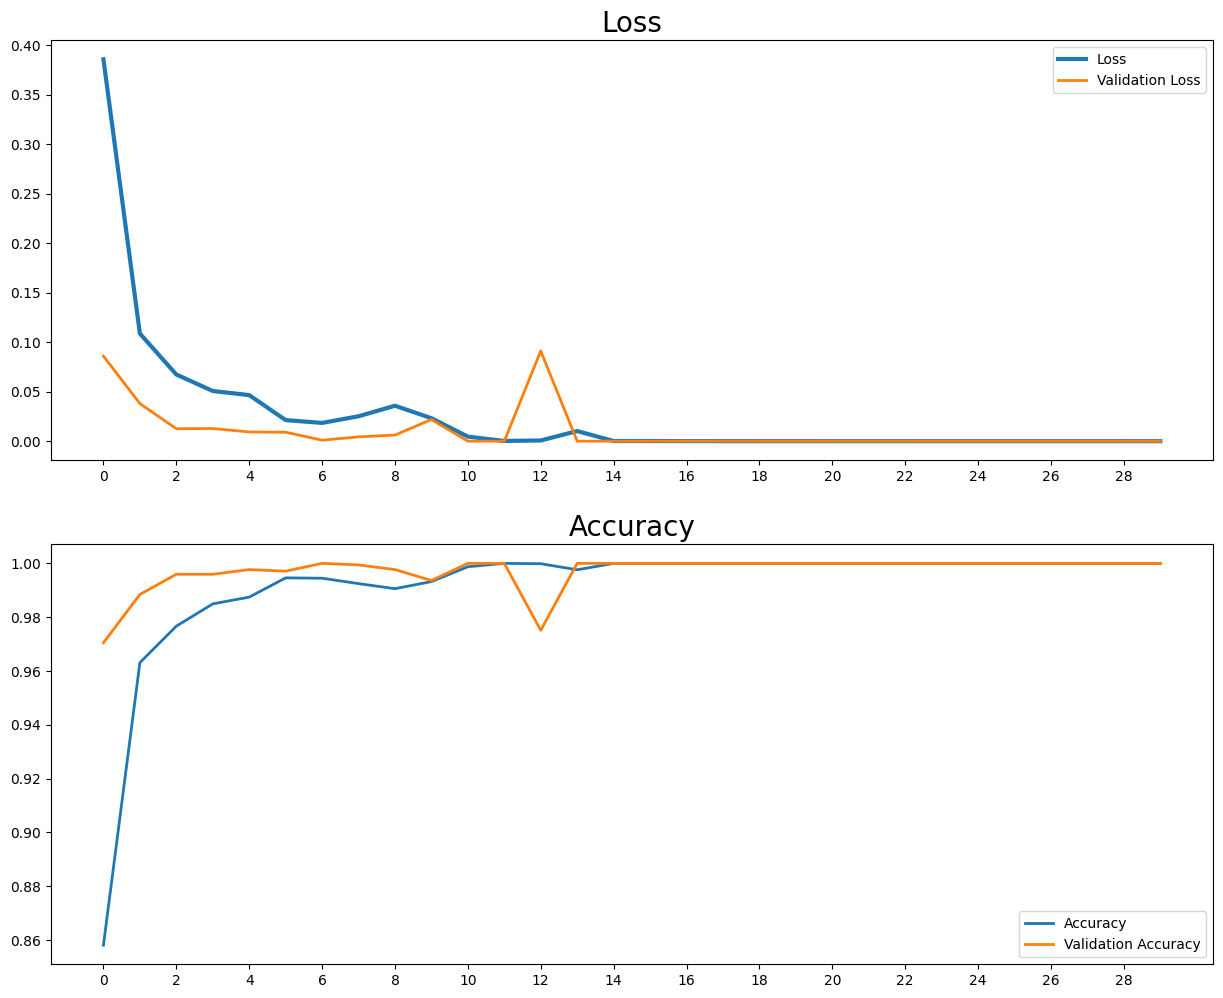

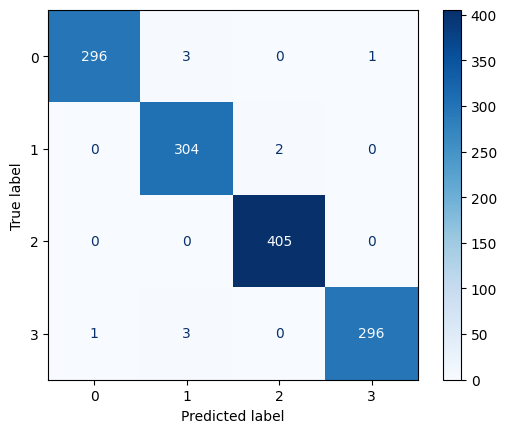

In [30]:
models = [
    (model_name_1, aug_b0, history_aug_b0, training_time_1)
]

best_model_name, test_loss, test_acc, test_f1score, best_time = best_variant(
    models=models,
    test_ds=test_ds_300,
    output_csv='EfficientNetV2B0 With Agumentation.csv',
    output_folder='results'
)

In [63]:
result(best_model_name, test_loss, test_acc, test_f1score, result_dict, best_time)

# Convert result_dict to a DataFrame
df = pd.DataFrame(result_dict)

# Convert any TensorFlow tensors in the F1Score column to numpy for better readability
df['Test F1Score'] = df['Test F1Score'].apply(lambda x: x.numpy() if hasattr(x, 'numpy') else x)

# Print the DataFrame as a table
print("Result Dictionary Table:")
print(df)


Results saved to results/result.csv
Result Dictionary Table:
                                          Model Name  Test Loss  \
0  EfficientnetV2B0 Without Augmentation Trainabl...   0.061502   
1  EfficientnetV2B3 Without Augmentation Trainabl...   0.076138   
2  EfficientnetV2M Without Augmentation Trainable...   0.072342   
3  EfficientnetV2B0 with Augmentation Trainable F...   0.076205   

   Test Accuracy  Test F1Score  Training Time  
0       0.987796      0.975689     217.560134  
1       0.985507      0.972358     367.200194  
2       0.992372      0.987013     814.237767  
3       0.989321      0.982172     408.734200  


### EfficientNetV2B3

In [31]:
model_name_2 = "EfficientnetV2B3 With Augmentation Trainable Last 75% Layer"
input_shape = (300,300,3)

aug_b3 = build_model_trainable_last75(EfficientNetV2B3, input_shape=input_shape, num_classes=4)
aug_b3, history_aug_b3, training_time_2 = train(aug_b3, model_name_2, train_aug_300, valid_aug_300, EPOCHS, SAVE_DIRECTORY)

52606240/52606240 [==============================] - 3s 0us/step
Epoch 1/30


2024-12-28 02:59:42.333245: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


498/498 [==============================] - ETA: 0s - loss: 0.3142 - accuracy: 0.8864 - f1_score: 0.8840

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


498/498 [==============================] - 34s 34ms/step - loss: 0.3142 - accuracy: 0.8864 - f1_score: 0.8840 - val_loss: 0.0485 - val_accuracy: 0.9861 - val_f1_score: 0.9858 - lr: 1.0000e-04
Epoch 2/30
498/498 [==============================] - 16s 32ms/step - loss: 0.0854 - accuracy: 0.9754 - f1_score: 0.9748 - val_loss: 0.0182 - val_accuracy: 0.9948 - val_f1_score: 0.9947 - lr: 1.0000e-04
Epoch 3/30
498/498 [==============================] - 16s 31ms/step - loss: 0.0446 - accuracy: 0.9861 - f1_score: 0.9858 - val_loss: 0.0301 - val_accuracy: 0.9873 - val_f1_score: 0.9872 - lr: 1.0000e-04
Epoch 4/30
498/498 [==============================] - 16s 32ms/step - loss: 0.0248 - accuracy: 0.9928 - f1_score: 0.9927 - val_loss: 0.0144 - val_accuracy: 0.9959 - val_f1_score: 0.9959 - lr: 1.0000e-04
Epoch 5/30
498/498 [==============================] - 16s 32ms/step - loss: 0.0290 - accuracy: 0.9920 - f1_score: 0.9918 - val_loss: 0.0072 - val_accuracy: 0.9977 - val_f1_score: 0.9976 - lr: 1.0000e

Model comparison table saved to results/EfficientNetV2B3 With Agumentation.csv
Model Comparison Table:
                                          Model Name          Loss  Accuracy  \
0  EfficientnetV2B3 With Augmentation Trainable L...  9.733982e-08       1.0   

   F1 Score  Training Time  
0       1.0     486.459036  
Accuracy and Loss plot saved to results/EfficientnetV2B3 With Augmentation Trainable Last 75% Layer/EfficientnetV2B3 With Augmentation Trainable Last 75% Layer_acc_loss_plot.png
1/1 [==============================] - 0s 17ms/step
Confusion Matrix plot saved to results/EfficientnetV2B3 With Augmentation Trainable Last 75% Layer/EfficientnetV2B3 With Augmentation Trainable Last 75% Layer_confusion_matrix.png
Classification Report
              precision    recall  f1-score   support

           0    0.99664   0.99000   0.99331       300
           1    0.98701   0.99346   0.99023       306
           2    0.99509   1.00000   0.99754       405
           3    0.99664   0.9

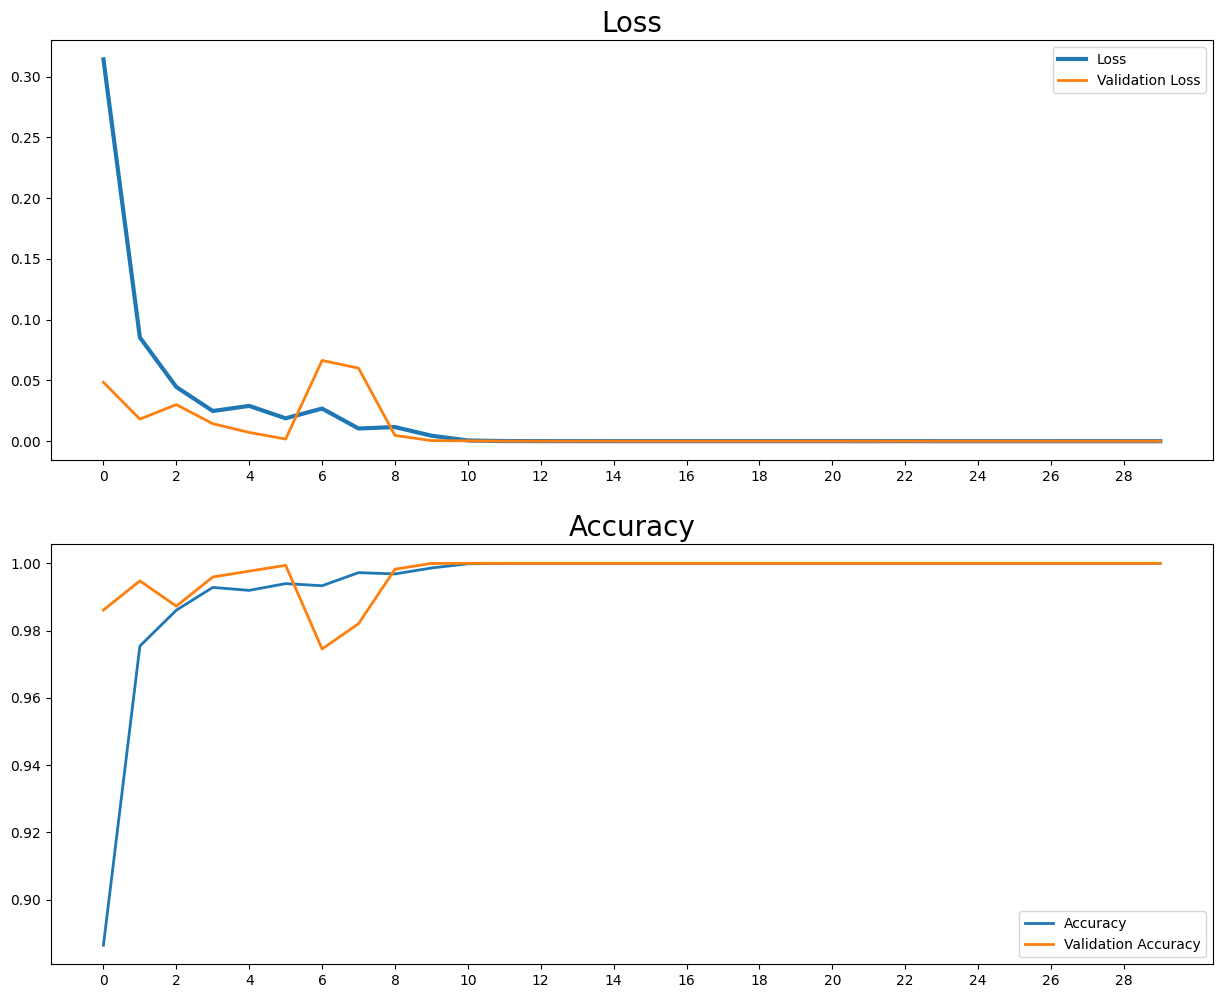

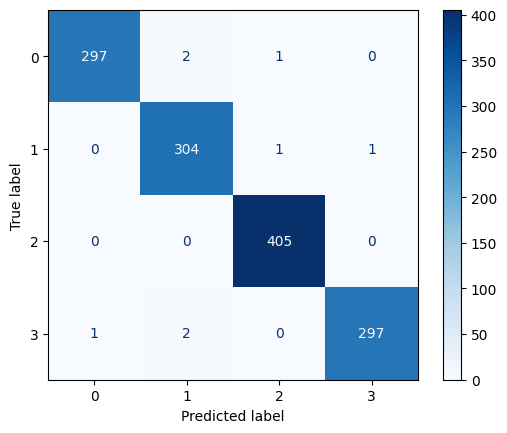

In [32]:
models = [
    (model_name_2, aug_b3, history_aug_b3, training_time_2)
]

best_model_name, test_loss, test_acc, test_f1score, best_time = best_variant(
    models=models,
    test_ds=test_ds_300,
    output_csv='EfficientNetV2B3 With Agumentation.csv',
    output_folder='results'
)

In [66]:
result(best_model_name, test_loss, test_acc, test_f1score, result_dict, best_time)

# Convert result_dict to a DataFrame
df = pd.DataFrame(result_dict)

# Convert any TensorFlow tensors in the F1Score column to numpy for better readability
df['Test F1Score'] = df['Test F1Score'].apply(lambda x: x.numpy() if hasattr(x, 'numpy') else x)

# Print the DataFrame as a table
print("Result Dictionary Table:")
print(df)

Results saved to results/result.csv
Result Dictionary Table:
                                          Model Name  Test Loss  \
0  EfficientnetV2B0 Without Augmentation Trainabl...   0.061502   
1  EfficientnetV2B3 Without Augmentation Trainabl...   0.076138   
2  EfficientnetV2M Without Augmentation Trainable...   0.072342   
3  EfficientnetV2B0 with Augmentation Trainable F...   0.076205   
4  EfficientnetV2B3 With Augmentation Trainable F...   0.052012   

   Test Accuracy  Test F1Score  Training Time  
0       0.987796      0.975689     217.560134  
1       0.985507      0.972358     367.200194  
2       0.992372      0.987013     814.237767  
3       0.989321      0.982172     408.734200  
4       0.990084      0.982172     673.797279  


### EfficientNetV2M

In [34]:
model_name_3 = "EfficientnetV2M With Augmentation Trainable Last 75% Layer"
input_shape = (300,300,3)

aug_m = build_model_trainable_last75(EfficientNetV2M, input_shape=input_shape, num_classes=4)
aug_m, history_aug_m, training_time_3 = train(aug_m, model_name_3, train_aug_300, valid_aug_300, EPOCHS, SAVE_DIRECTORY)

214201816/214201816 [==============================] - 8s 0us/step
Epoch 1/30


2024-12-28 03:09:40.867523: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


498/498 [==============================] - ETA: 0s - loss: 0.4091 - accuracy: 0.8461 - f1_score: 0.8434

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


498/498 [==============================] - 69s 75ms/step - loss: 0.4091 - accuracy: 0.8461 - f1_score: 0.8434 - val_loss: 0.0563 - val_accuracy: 0.9821 - val_f1_score: 0.9818 - lr: 1.0000e-04
Epoch 2/30
498/498 [==============================] - 36s 73ms/step - loss: 0.0980 - accuracy: 0.9691 - f1_score: 0.9684 - val_loss: 0.0208 - val_accuracy: 0.9931 - val_f1_score: 0.9929 - lr: 1.0000e-04
Epoch 3/30
498/498 [==============================] - 35s 70ms/step - loss: 0.0602 - accuracy: 0.9833 - f1_score: 0.9829 - val_loss: 0.0785 - val_accuracy: 0.9797 - val_f1_score: 0.9794 - lr: 1.0000e-04
Epoch 4/30
498/498 [==============================] - 35s 70ms/step - loss: 0.0426 - accuracy: 0.9888 - f1_score: 0.9887 - val_loss: 0.0273 - val_accuracy: 0.9925 - val_f1_score: 0.9922 - lr: 1.0000e-04
Epoch 5/30
498/498 [==============================] - 36s 73ms/step - loss: 0.0481 - accuracy: 0.9892 - f1_score: 0.9891 - val_loss: 0.0112 - val_accuracy: 0.9965 - val_f1_score: 0.9964 - lr: 1.0000e

Model comparison table saved to results/EfficientNetV2M With Agumentation.csv
Model Comparison Table:
                                          Model Name          Loss  Accuracy  \
0  EfficientnetV2M With Augmentation Trainable La...  2.130013e-07       1.0   

   F1 Score  Training Time  
0       1.0    1089.556586  
Accuracy and Loss plot saved to results/EfficientnetV2M With Augmentation Trainable Last 75% Layer/EfficientnetV2M With Augmentation Trainable Last 75% Layer_acc_loss_plot.png
1/1 [==============================] - 0s 20ms/step
Confusion Matrix plot saved to results/EfficientnetV2M With Augmentation Trainable Last 75% Layer/EfficientnetV2M With Augmentation Trainable Last 75% Layer_confusion_matrix.png
Classification Report
              precision    recall  f1-score   support

           0    0.99660   0.97667   0.98653       300
           1    0.97735   0.98693   0.98211       306
           2    0.99754   1.00000   0.99877       405
           3    0.98675   0.99333 

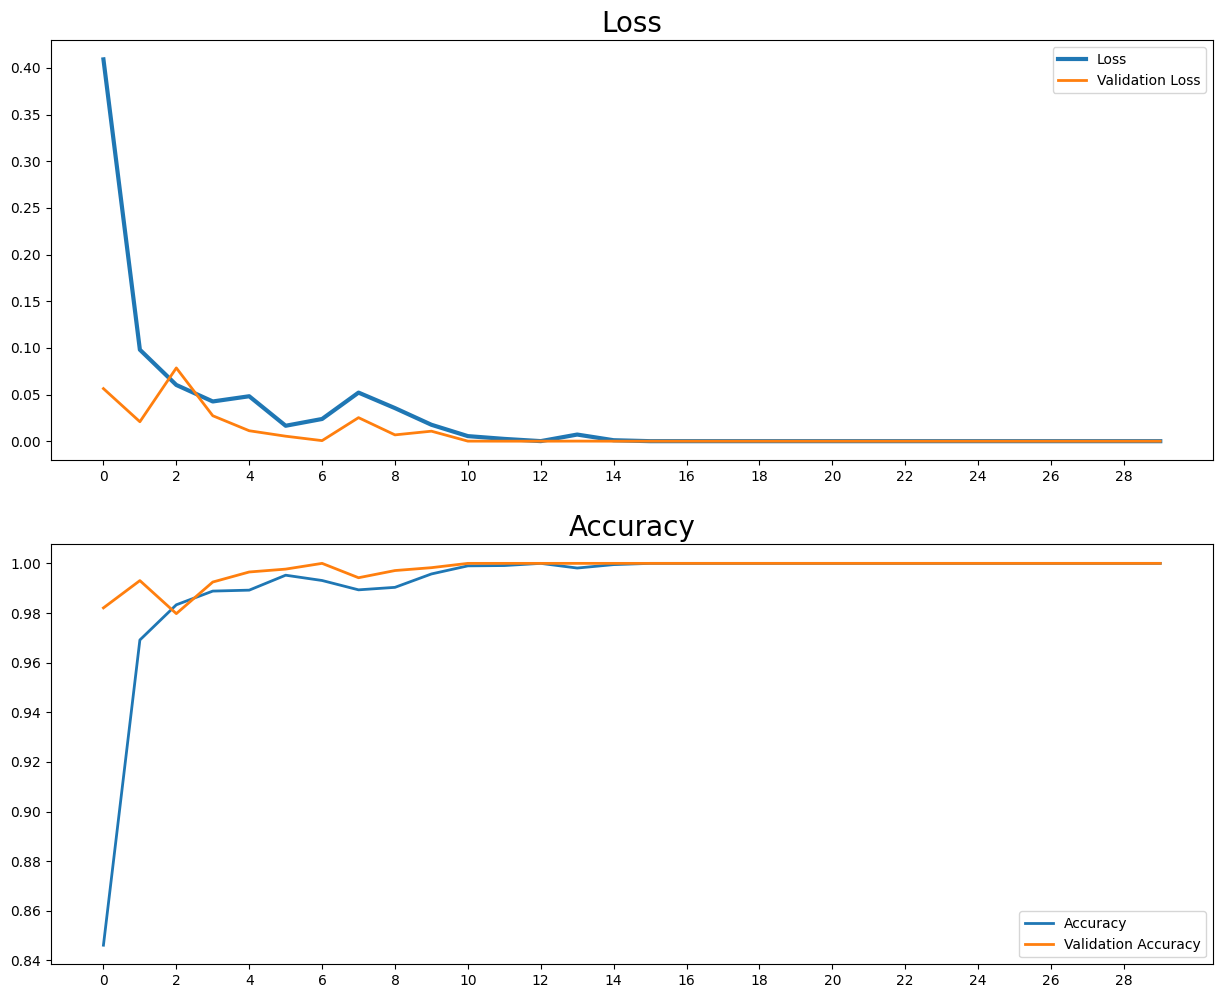

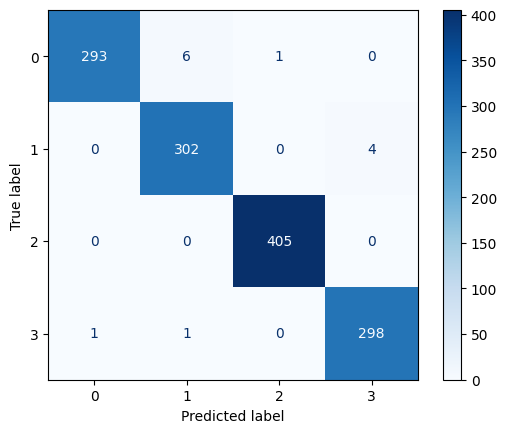

In [35]:
models = [
    (model_name_3, aug_m, history_aug_m, training_time_3)
]

best_model_name, test_loss, test_acc, test_f1score, best_time = best_variant(
    models=models,
    test_ds=test_ds_300,
    output_csv='EfficientNetV2M With Agumentation.csv',
    output_folder='results'
)

In [70]:
result(best_model_name, test_loss, test_acc, test_f1score, result_dict, best_time)

# Convert result_dict to a DataFrame
df = pd.DataFrame(result_dict)

# Convert any TensorFlow tensors in the F1Score column to numpy for better readability
df['Test F1Score'] = df['Test F1Score'].apply(lambda x: x.numpy() if hasattr(x, 'numpy') else x)

# Print the DataFrame as a table
print("Result Dictionary Table:")
print(df)

Results saved to results/result.csv
Result Dictionary Table:
                                          Model Name  Test Loss  \
0  EfficientnetV2B0 Without Augmentation Trainabl...   0.061502   
1  EfficientnetV2B3 Without Augmentation Trainabl...   0.076138   
2  EfficientnetV2M Without Augmentation Trainable...   0.072342   
3  EfficientnetV2B0 with Augmentation Trainable F...   0.076205   
4  EfficientnetV2B3 With Augmentation Trainable F...   0.052012   
5  EfficientnetV2M With Augmentation Trainable Fi...   0.082550   

   Test Accuracy  Test F1Score  Training Time  
0       0.987796      0.975689     217.560134  
1       0.985507      0.972358     367.200194  
2       0.992372      0.987013     814.237767  
3       0.989321      0.982172     408.734200  
4       0.990084      0.982172     673.797279  
5       0.992372      0.988618    1481.217727  


### Combine All Results from Augmentation

Model comparison table saved to results/Agumentation.csv
Model Comparison Table:
                                          Model Name          Loss  Accuracy  \
0  EfficientnetV2B0 with Augmentation Full Trainable  9.637273e-07       1.0   
1  EfficientnetV2B3 With Augmentation Trainable L...  9.733982e-08       1.0   
2  EfficientnetV2M With Augmentation Trainable La...  2.130013e-07       1.0   

   F1 Score  Training Time  
0       1.0     396.749113  
1       1.0     486.459036  
2       1.0    1089.556586  
Accuracy and Loss plot saved to results/EfficientnetV2B0 with Augmentation Full Trainable/EfficientnetV2B0 with Augmentation Full Trainable_acc_loss_plot.png
1/1 [==============================] - 0s 15ms/step
Confusion Matrix plot saved to results/EfficientnetV2B0 with Augmentation Full Trainable/EfficientnetV2B0 with Augmentation Full Trainable_confusion_matrix.png
Classification Report
              precision    recall  f1-score   support

           0    0.99663   0.98667  

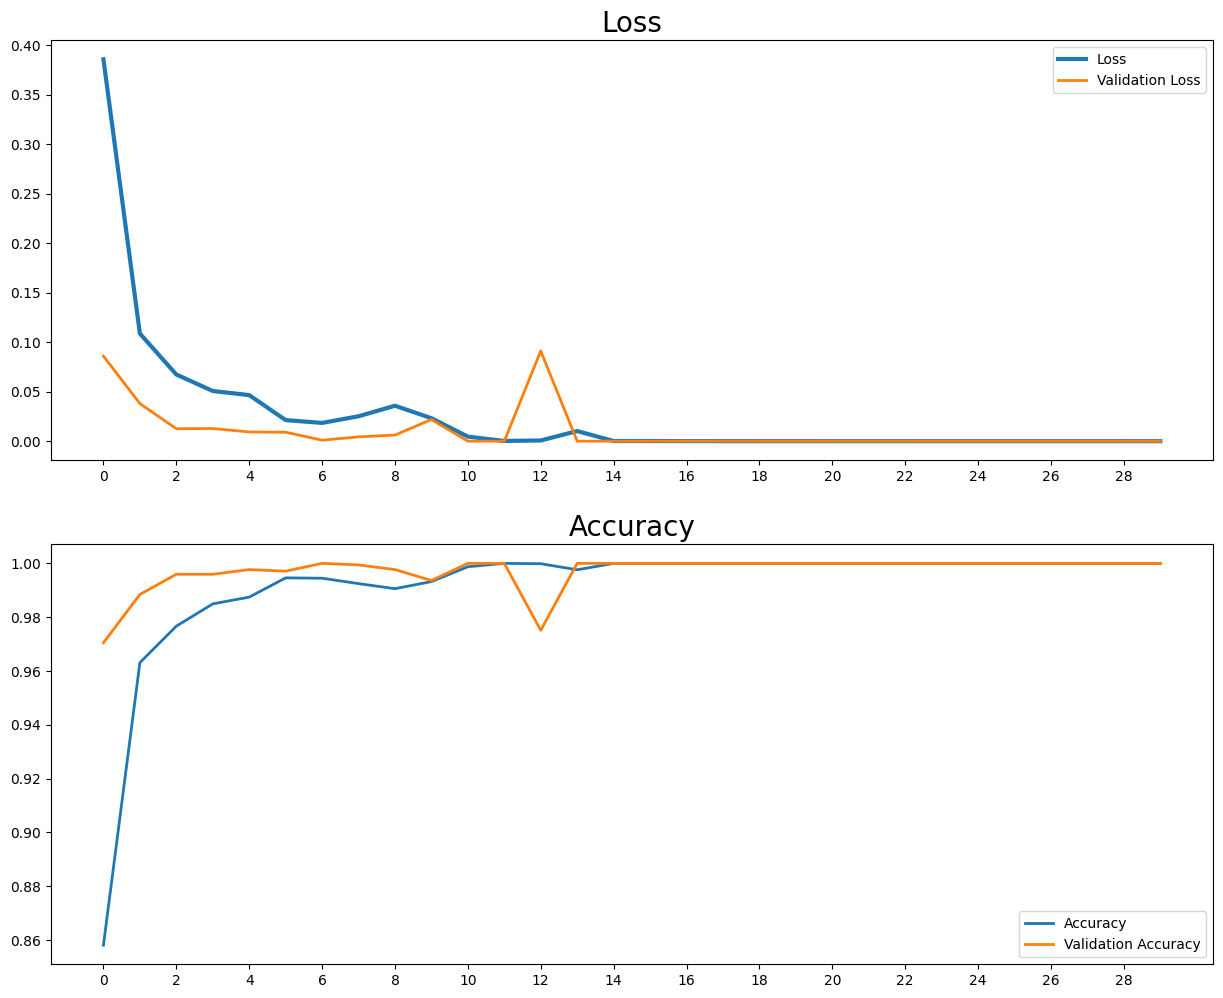

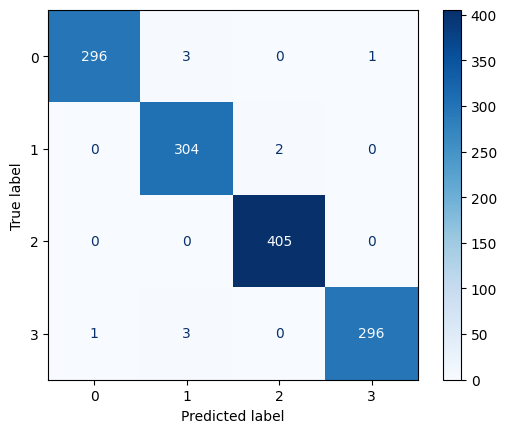

In [36]:
models = [
    (model_name_1, aug_b0, history_aug_b0, training_time_1),
    (model_name_2, aug_b3, history_aug_b3, training_time_2),
    (model_name_3, aug_m, history_aug_m, training_time_3)
]

best_model_name, test_loss, test_acc, test_f1score, best_time = best_variant(
    models=models,
    test_ds=test_ds_300,
    output_csv='Agumentation.csv',
    output_folder='results'
)

# Testing Model

In [35]:
def plot(model, test_ds, output_folder='results', prefix='model'):
    """
    Plot training results, confusion matrix, and save plots to files.

    Args:
        model: The trained model.
        history: Training history object from model.fit().
        test_ds: Test dataset for evaluation.
        output_folder (str): Directory to save plots.
        prefix (str): Prefix for output file names.

    Returns:
        Tuple containing history, test loss, test accuracy, and test F1 score.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Evaluate model
    time1 = time.time()
    test_loss, test_acc, test_f1score = model.evaluate(test_ds, verbose=1)
    time2 = time.time()

    waktu = time2 - time1
    print(f"inference time: {waktu}")
    
    # Confusion Matrix
    y_pred = []
    y_true = []

    for images, labels in test_ds:
        predictions = model.predict(images)
        y_pred.extend(np.argmax(predictions, axis=1))

        # If labels are one-hot encoded, convert to class indices
        if len(labels.shape) > 1:
            labels = np.argmax(labels, axis=1)
        y_true.extend(labels)

    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Get the class names from the dataset
    class_names = sorted(set(y_true))  # Infer class names from true labels

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)

    # Save confusion matrix plot
    cm_plot_path = os.path.join(output_folder, f"{prefix}_confusion_matrix.png")
    plt.savefig(cm_plot_path)
    print(f"Confusion Matrix plot saved to {cm_plot_path}")

    # Classification Report
    print('Classification Report')
    cr = classification_report(y_true, y_pred, digits=5, target_names=[str(c) for c in class_names])
    print(cr)

    # Save classification report to a text file
    cr_path = os.path.join(output_folder, f"{prefix}_classification_report.txt")
    with open(cr_path, 'w') as f:
        f.write('Classification Report\n')
        f.write(cr)
    print(f"Classification Report saved to {cr_path}")

    # Show all plots
    plt.show()

    return test_loss, test_acc, test_f1score

In [36]:
import time

82/82 [==============================] - 2s 9ms/step - loss: 0.0447 - accuracy: 0.9886 - f1_score: 0.9879
inference time: 1.7790298461914062
1/1 [==============================] - 0s 16ms/step
Confusion Matrix plot saved to results//workspace/model/model_EfficientnetV2B0 with Augmentation Full Trainable.h5/model_path_confusion_matrix.png
Classification Report
              precision    recall  f1-score   support

           0    1.00000   0.97333   0.98649       300
           1    0.95899   0.99346   0.97592       306
           2    0.99509   1.00000   0.99754       405
           3    1.00000   0.98333   0.99160       300

    accuracy                        0.98856      1311
   macro avg    0.98852   0.98753   0.98789      1311
weighted avg    0.98891   0.98856   0.98860      1311

Classification Report saved to results//workspace/model/model_EfficientnetV2B0 with Augmentation Full Trainable.h5/model_path_classification_report.txt


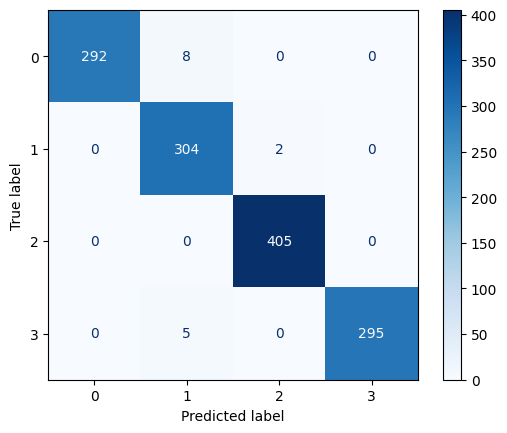

In [41]:
# Load your saved model
model_path = os.path.join(CWD, "model", "model_EfficientnetV2B0 with Augmentation Full Trainable.h5")
model = tf.keras.models.load_model(model_path)

# Call the plot function
results = plot(model, test_ds_300, output_folder=f"results/{model_path}", prefix='model_path')


82/82 [==============================] - 3s 14ms/step - loss: 0.0405 - accuracy: 0.9947 - f1_score: 0.9944
inference time: 3.203256130218506
1/1 [==============================] - 0s 17ms/step
Confusion Matrix plot saved to results//workspace/model/model_EfficientnetV2B3 With Augmentation Trainable Last 75% Layer.h5/model_path_confusion_matrix.png
Classification Report
              precision    recall  f1-score   support

           0    0.99664   0.99000   0.99331       300
           1    0.98706   0.99673   0.99187       306
           2    0.99509   1.00000   0.99754       405
           3    1.00000   0.99000   0.99497       300

    accuracy                        0.99466      1311
   macro avg    0.99470   0.99418   0.99442      1311
weighted avg    0.99469   0.99466   0.99466      1311

Classification Report saved to results//workspace/model/model_EfficientnetV2B3 With Augmentation Trainable Last 75% Layer.h5/model_path_classification_report.txt


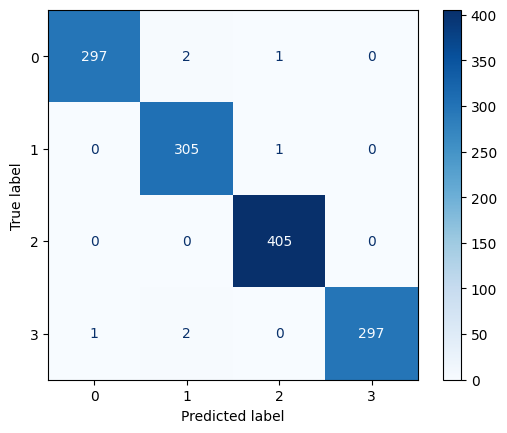

In [42]:
# Load your saved model
model_path = os.path.join(CWD, "model", "model_EfficientnetV2B3 With Augmentation Trainable Last 75% Layer.h5")
model = tf.keras.models.load_model(model_path)

# Call the plot function
results = plot(model, test_ds_300, output_folder=f"results/{model_path}", prefix='model_path')

82/82 [==============================] - 5s 25ms/step - loss: 0.0550 - accuracy: 0.9931 - f1_score: 0.9927
inference time: 5.369097709655762
1/1 [==============================] - 0s 19ms/step
Confusion Matrix plot saved to results//workspace/model/model_EfficientnetV2M With Augmentation Trainable Last 75% Layer.h5/model_path_confusion_matrix.png
Classification Report
              precision    recall  f1-score   support

           0    0.99333   0.99333   0.99333       300
           1    0.99020   0.99020   0.99020       306
           2    1.00000   0.99753   0.99876       405
           3    0.98671   0.99000   0.98835       300

    accuracy                        0.99314      1311
   macro avg    0.99256   0.99277   0.99266      1311
weighted avg    0.99315   0.99314   0.99314      1311

Classification Report saved to results//workspace/model/model_EfficientnetV2M With Augmentation Trainable Last 75% Layer.h5/model_path_classification_report.txt


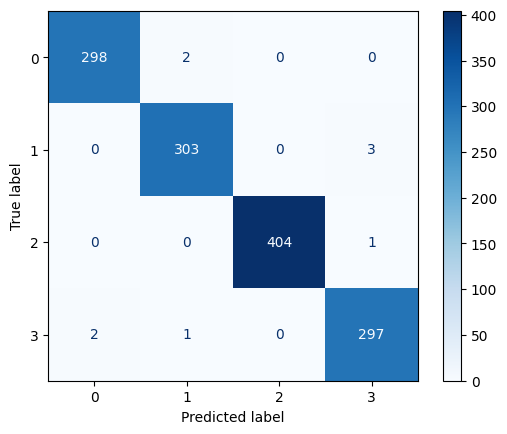

In [43]:
# Load your saved model
model_path = os.path.join(CWD, "model", "model_EfficientnetV2M With Augmentation Trainable Last 75% Layer.h5")
model = tf.keras.models.load_model(model_path)

# Call the plot function
results = plot(model, test_ds_300, output_folder=f"results/{model_path}", prefix='model_path')


# Result

In [ ]:
f"results/{best_model_name}",  best_model_name

In [73]:
results = pd.DataFrame(result_dict)

print(results)

                                          Model Name  Test Loss  \
0  EfficientnetV2B0 Without Augmentation Trainabl...   0.061502   
1  EfficientnetV2B3 Without Augmentation Trainabl...   0.076138   
2  EfficientnetV2M Without Augmentation Trainable...   0.072342   
3  EfficientnetV2B0 with Augmentation Trainable F...   0.076205   
4  EfficientnetV2B3 With Augmentation Trainable F...   0.052012   
5  EfficientnetV2M With Augmentation Trainable Fi...   0.082550   

   Test Accuracy  Test F1Score  Training Time  
0       0.987796      0.975689     217.560134  
1       0.985507      0.972358     367.200194  
2       0.992372      0.987013     814.237767  
3       0.989321      0.982172     408.734200  
4       0.990084      0.982172     673.797279  
5       0.992372      0.988618    1481.217727  


In [74]:
results.to_csv("results.csv", index=False)

df = pd.read_csv("results.csv")

print(df)

                                          Model Name  Test Loss  \
0  EfficientnetV2B0 Without Augmentation Trainabl...   0.061502   
1  EfficientnetV2B3 Without Augmentation Trainabl...   0.076138   
2  EfficientnetV2M Without Augmentation Trainable...   0.072342   
3  EfficientnetV2B0 with Augmentation Trainable F...   0.076205   
4  EfficientnetV2B3 With Augmentation Trainable F...   0.052012   
5  EfficientnetV2M With Augmentation Trainable Fi...   0.082550   

   Test Accuracy  Test F1Score  Training Time  
0       0.987796      0.975689     217.560134  
1       0.985507      0.972358     367.200194  
2       0.992372      0.987013     814.237767  
3       0.989321      0.982172     408.734200  
4       0.990084      0.982172     673.797279  
5       0.992372      0.988618    1481.217727  
